# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

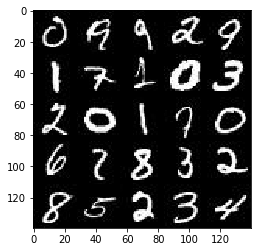

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

58800

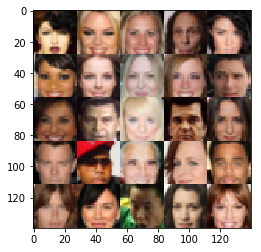

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [19]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels],
                                      name='input')
    z_data = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')

    return real_input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [91]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # input=28x28xnum_channels
        x1 = tf.layers.conv2d(images, 128, 4, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # output= 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 4, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * x2, x2)
        # Output= 7x7x256
        
        x3 = tf.layers.conv2d(relu2, 512, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * x3, x3)
        # output= 4x4x512
        
        x4 = tf.layers.conv2d(relu2, 1024, 4, strides=4, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * x4, x4)
        # output=
        
        flat = tf.reshape(relu4, (-1, 4*4*1024))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [92]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # z= 28*28*num_channels; for mnist=784 & celebA=2352
        x1 = tf.layers.dense(z, 4*4*1024)
        # Reshape to match discrim structure
        
        x1 = tf.reshape(x1, (-1, 4, 4, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # output= 4x4x1024
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # output= 7x7x512
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 4, strides=1, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # output= 10x10x256
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 4, strides=1, padding='valid')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # output= 13x13x128
        
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 4, strides=2, padding='valid')
        # ouput= 28x28xnum_channels
        
        
        out = tf.tanh(logits)        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [93]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [94]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [95]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [96]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    input_real, input_z, train_learning_rate = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, train_learning_rate, beta1)
    
    print_every = 10
    show_every = 100
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model'
                steps += 1
                
                # Sample random noise for gen
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                
                # Run Optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               train_learning_rate: learning_rate})
                
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               train_learning_rate: learning_rate})
                
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               train_learning_rate: learning_rate})
                
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               train_learning_rate: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z,
                                               input_real: batch_images,
                                               train_learning_rate: learning_rate})
                    
                    train_loss_g = g_loss.eval({input_z: batch_z,
                                               input_real: batch_images,
                                               train_learning_rate: learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                         "Discriminator Loss: {:.4f}...".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    if steps % show_every == 0:
                        show_generator_output(sess, 16, input_z,data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 5.5356... Generator Loss: 0.0079
Epoch 1/2... Discriminator Loss: 6.3159... Generator Loss: 0.0043
Epoch 1/2... Discriminator Loss: 6.7923... Generator Loss: 0.0123
Epoch 1/2... Discriminator Loss: 3.8667... Generator Loss: 0.0342
Epoch 1/2... Discriminator Loss: 4.6046... Generator Loss: 0.0436
Epoch 1/2... Discriminator Loss: 4.1493... Generator Loss: 0.0348
Epoch 1/2... Discriminator Loss: 3.9320... Generator Loss: 0.0809
Epoch 1/2... Discriminator Loss: 3.3782... Generator Loss: 0.0397
Epoch 1/2... Discriminator Loss: 2.9418... Generator Loss: 0.0615
Epoch 1/2... Discriminator Loss: 3.3496... Generator Loss: 0.0757


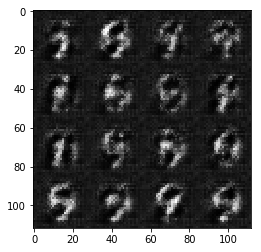

Epoch 1/2... Discriminator Loss: 2.9061... Generator Loss: 0.1092
Epoch 1/2... Discriminator Loss: 3.2189... Generator Loss: 0.1040
Epoch 1/2... Discriminator Loss: 3.2988... Generator Loss: 0.0820
Epoch 1/2... Discriminator Loss: 3.2271... Generator Loss: 0.0436
Epoch 1/2... Discriminator Loss: 3.2524... Generator Loss: 0.0461
Epoch 1/2... Discriminator Loss: 2.8735... Generator Loss: 0.0644
Epoch 1/2... Discriminator Loss: 2.9755... Generator Loss: 0.0561
Epoch 1/2... Discriminator Loss: 2.7569... Generator Loss: 0.0707
Epoch 1/2... Discriminator Loss: 2.8813... Generator Loss: 0.0607
Epoch 1/2... Discriminator Loss: 2.5992... Generator Loss: 0.1032


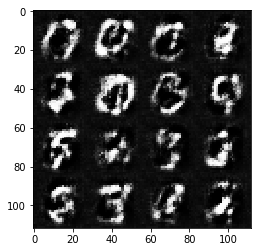

Epoch 1/2... Discriminator Loss: 2.7892... Generator Loss: 0.1764
Epoch 1/2... Discriminator Loss: 2.9014... Generator Loss: 0.1113
Epoch 1/2... Discriminator Loss: 3.2164... Generator Loss: 0.1362
Epoch 1/2... Discriminator Loss: 2.8823... Generator Loss: 0.0682
Epoch 1/2... Discriminator Loss: 2.7627... Generator Loss: 0.1261
Epoch 1/2... Discriminator Loss: 2.5314... Generator Loss: 0.1415
Epoch 1/2... Discriminator Loss: 2.6154... Generator Loss: 0.1772
Epoch 1/2... Discriminator Loss: 2.9913... Generator Loss: 0.2191
Epoch 1/2... Discriminator Loss: 2.6969... Generator Loss: 0.1976
Epoch 1/2... Discriminator Loss: 2.4363... Generator Loss: 0.1354


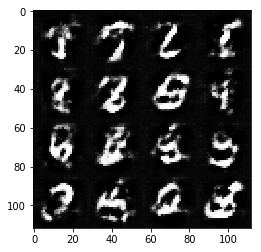

Epoch 1/2... Discriminator Loss: 2.5714... Generator Loss: 0.1991
Epoch 1/2... Discriminator Loss: 2.5224... Generator Loss: 0.1250
Epoch 1/2... Discriminator Loss: 2.5156... Generator Loss: 0.2629
Epoch 1/2... Discriminator Loss: 2.8788... Generator Loss: 0.1158
Epoch 1/2... Discriminator Loss: 2.4235... Generator Loss: 0.1196
Epoch 1/2... Discriminator Loss: 2.7593... Generator Loss: 0.0747
Epoch 1/2... Discriminator Loss: 2.7114... Generator Loss: 0.0745
Epoch 1/2... Discriminator Loss: 2.5068... Generator Loss: 0.1012
Epoch 1/2... Discriminator Loss: 2.6350... Generator Loss: 0.0828
Epoch 1/2... Discriminator Loss: 2.7649... Generator Loss: 0.0706


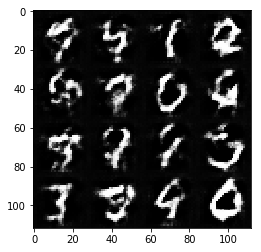

Epoch 1/2... Discriminator Loss: 2.6337... Generator Loss: 0.0873
Epoch 1/2... Discriminator Loss: 2.4683... Generator Loss: 0.1040
Epoch 1/2... Discriminator Loss: 2.1597... Generator Loss: 0.1936
Epoch 1/2... Discriminator Loss: 2.5629... Generator Loss: 0.1516
Epoch 1/2... Discriminator Loss: 2.6676... Generator Loss: 0.2022
Epoch 1/2... Discriminator Loss: 2.4837... Generator Loss: 0.1901
Epoch 1/2... Discriminator Loss: 2.5036... Generator Loss: 0.1158
Epoch 1/2... Discriminator Loss: 2.7601... Generator Loss: 0.1411
Epoch 1/2... Discriminator Loss: 2.4359... Generator Loss: 0.2367
Epoch 1/2... Discriminator Loss: 2.4682... Generator Loss: 0.1433


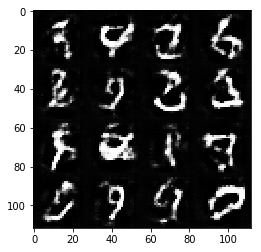

Epoch 1/2... Discriminator Loss: 2.3311... Generator Loss: 0.1505
Epoch 1/2... Discriminator Loss: 2.5700... Generator Loss: 0.0896
Epoch 1/2... Discriminator Loss: 2.5526... Generator Loss: 0.0918
Epoch 1/2... Discriminator Loss: 2.5066... Generator Loss: 0.2237
Epoch 1/2... Discriminator Loss: 2.4226... Generator Loss: 0.1274
Epoch 1/2... Discriminator Loss: 2.6322... Generator Loss: 0.2050
Epoch 1/2... Discriminator Loss: 2.4762... Generator Loss: 0.1106
Epoch 1/2... Discriminator Loss: 2.5102... Generator Loss: 0.0971
Epoch 1/2... Discriminator Loss: 2.7018... Generator Loss: 0.0781
Epoch 1/2... Discriminator Loss: 2.7202... Generator Loss: 0.0725


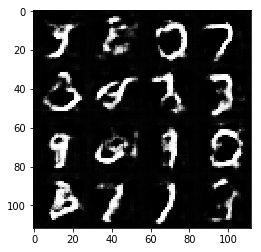

Epoch 1/2... Discriminator Loss: 2.5777... Generator Loss: 0.1740
Epoch 1/2... Discriminator Loss: 2.4698... Generator Loss: 0.1607
Epoch 1/2... Discriminator Loss: 2.2842... Generator Loss: 0.2287
Epoch 1/2... Discriminator Loss: 2.7193... Generator Loss: 0.0807
Epoch 1/2... Discriminator Loss: 2.4180... Generator Loss: 0.1319
Epoch 1/2... Discriminator Loss: 2.5283... Generator Loss: 0.1730
Epoch 1/2... Discriminator Loss: 2.5634... Generator Loss: 0.2952
Epoch 1/2... Discriminator Loss: 2.3589... Generator Loss: 0.1414
Epoch 1/2... Discriminator Loss: 2.2996... Generator Loss: 0.1796
Epoch 1/2... Discriminator Loss: 2.4521... Generator Loss: 0.1028


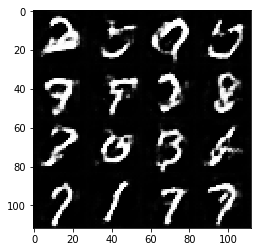

Epoch 1/2... Discriminator Loss: 2.2450... Generator Loss: 0.2509
Epoch 1/2... Discriminator Loss: 2.5664... Generator Loss: 0.1942
Epoch 1/2... Discriminator Loss: 2.4864... Generator Loss: 0.2714
Epoch 1/2... Discriminator Loss: 2.4167... Generator Loss: 0.1458
Epoch 1/2... Discriminator Loss: 2.4327... Generator Loss: 0.1036
Epoch 1/2... Discriminator Loss: 2.6350... Generator Loss: 0.0835
Epoch 1/2... Discriminator Loss: 2.2711... Generator Loss: 0.1982
Epoch 1/2... Discriminator Loss: 2.4611... Generator Loss: 0.1519
Epoch 1/2... Discriminator Loss: 2.2304... Generator Loss: 0.3045
Epoch 1/2... Discriminator Loss: 2.7928... Generator Loss: 0.2727


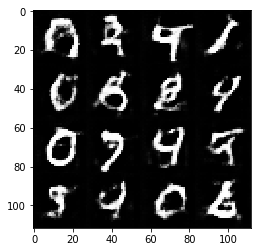

Epoch 1/2... Discriminator Loss: 2.5287... Generator Loss: 0.2513
Epoch 1/2... Discriminator Loss: 2.2200... Generator Loss: 0.2245
Epoch 1/2... Discriminator Loss: 2.5960... Generator Loss: 0.2226
Epoch 1/2... Discriminator Loss: 2.7135... Generator Loss: 0.0791
Epoch 1/2... Discriminator Loss: 2.3488... Generator Loss: 0.1979
Epoch 1/2... Discriminator Loss: 2.3272... Generator Loss: 0.2596
Epoch 1/2... Discriminator Loss: 2.5271... Generator Loss: 0.1026
Epoch 1/2... Discriminator Loss: 2.4621... Generator Loss: 0.1050
Epoch 1/2... Discriminator Loss: 2.7279... Generator Loss: 0.3308
Epoch 1/2... Discriminator Loss: 2.4700... Generator Loss: 0.1240


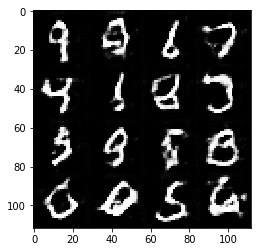

Epoch 1/2... Discriminator Loss: 2.3287... Generator Loss: 0.1634
Epoch 1/2... Discriminator Loss: 2.5046... Generator Loss: 0.0939
Epoch 1/2... Discriminator Loss: 2.6221... Generator Loss: 0.1152
Epoch 2/2... Discriminator Loss: 2.1104... Generator Loss: 0.3240
Epoch 2/2... Discriminator Loss: 2.5341... Generator Loss: 0.1134
Epoch 2/2... Discriminator Loss: 2.1884... Generator Loss: 0.1598
Epoch 2/2... Discriminator Loss: 2.1851... Generator Loss: 0.2132
Epoch 2/2... Discriminator Loss: 2.2383... Generator Loss: 0.2682
Epoch 2/2... Discriminator Loss: 2.1926... Generator Loss: 0.2834
Epoch 2/2... Discriminator Loss: 2.2528... Generator Loss: 0.1358


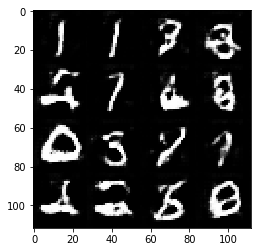

Epoch 2/2... Discriminator Loss: 2.3540... Generator Loss: 0.1153
Epoch 2/2... Discriminator Loss: 2.3355... Generator Loss: 0.1108
Epoch 2/2... Discriminator Loss: 2.2720... Generator Loss: 0.1619
Epoch 2/2... Discriminator Loss: 2.4912... Generator Loss: 0.2702
Epoch 2/2... Discriminator Loss: 2.1290... Generator Loss: 0.1932
Epoch 2/2... Discriminator Loss: 2.5575... Generator Loss: 0.0887
Epoch 2/2... Discriminator Loss: 2.2856... Generator Loss: 0.1299
Epoch 2/2... Discriminator Loss: 2.5873... Generator Loss: 0.0867
Epoch 2/2... Discriminator Loss: 2.6470... Generator Loss: 0.0835
Epoch 2/2... Discriminator Loss: 2.3787... Generator Loss: 0.1263


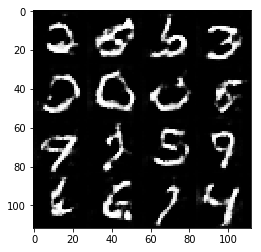

Epoch 2/2... Discriminator Loss: 2.6277... Generator Loss: 0.0841
Epoch 2/2... Discriminator Loss: 2.5704... Generator Loss: 0.1011
Epoch 2/2... Discriminator Loss: 2.3053... Generator Loss: 0.1273
Epoch 2/2... Discriminator Loss: 2.6626... Generator Loss: 0.0776
Epoch 2/2... Discriminator Loss: 2.0540... Generator Loss: 0.1681
Epoch 2/2... Discriminator Loss: 2.8745... Generator Loss: 0.3586
Epoch 2/2... Discriminator Loss: 2.0091... Generator Loss: 0.3510
Epoch 2/2... Discriminator Loss: 2.5235... Generator Loss: 0.0945
Epoch 2/2... Discriminator Loss: 2.0086... Generator Loss: 0.2826
Epoch 2/2... Discriminator Loss: 2.2754... Generator Loss: 0.4952


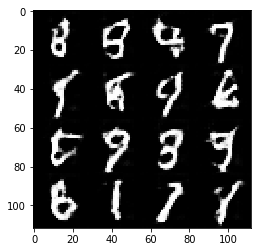

Epoch 2/2... Discriminator Loss: 1.9576... Generator Loss: 0.2015
Epoch 2/2... Discriminator Loss: 2.2754... Generator Loss: 0.8949
Epoch 2/2... Discriminator Loss: 2.3011... Generator Loss: 0.4643
Epoch 2/2... Discriminator Loss: 2.1022... Generator Loss: 0.1790
Epoch 2/2... Discriminator Loss: 2.2711... Generator Loss: 0.1574
Epoch 2/2... Discriminator Loss: 2.3883... Generator Loss: 0.1081
Epoch 2/2... Discriminator Loss: 2.3639... Generator Loss: 0.1145
Epoch 2/2... Discriminator Loss: 2.5714... Generator Loss: 0.0888
Epoch 2/2... Discriminator Loss: 2.2481... Generator Loss: 0.1399
Epoch 2/2... Discriminator Loss: 1.9447... Generator Loss: 0.3699


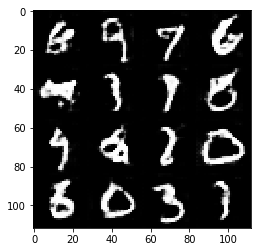

Epoch 2/2... Discriminator Loss: 1.8177... Generator Loss: 0.7880
Epoch 2/2... Discriminator Loss: 2.2107... Generator Loss: 0.1519
Epoch 2/2... Discriminator Loss: 2.4155... Generator Loss: 0.0997
Epoch 2/2... Discriminator Loss: 2.0897... Generator Loss: 0.1782
Epoch 2/2... Discriminator Loss: 2.1294... Generator Loss: 0.1767
Epoch 2/2... Discriminator Loss: 1.8945... Generator Loss: 0.3010
Epoch 2/2... Discriminator Loss: 3.6505... Generator Loss: 0.6515
Epoch 2/2... Discriminator Loss: 1.8810... Generator Loss: 0.2381
Epoch 2/2... Discriminator Loss: 2.1481... Generator Loss: 0.1489
Epoch 2/2... Discriminator Loss: 2.2573... Generator Loss: 0.1236


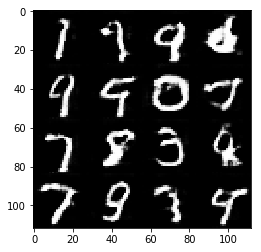

Epoch 2/2... Discriminator Loss: 2.0820... Generator Loss: 0.1618
Epoch 2/2... Discriminator Loss: 1.8411... Generator Loss: 0.3687
Epoch 2/2... Discriminator Loss: 2.2447... Generator Loss: 0.1519
Epoch 2/2... Discriminator Loss: 2.1497... Generator Loss: 0.8057
Epoch 2/2... Discriminator Loss: 2.1853... Generator Loss: 0.1353
Epoch 2/2... Discriminator Loss: 1.8484... Generator Loss: 0.2468
Epoch 2/2... Discriminator Loss: 2.7937... Generator Loss: 0.0709
Epoch 2/2... Discriminator Loss: 1.8970... Generator Loss: 0.2556
Epoch 2/2... Discriminator Loss: 2.0072... Generator Loss: 0.1871
Epoch 2/2... Discriminator Loss: 1.9543... Generator Loss: 0.3045


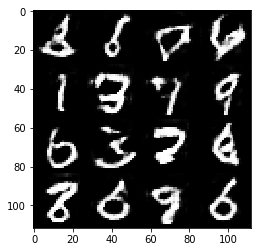

Epoch 2/2... Discriminator Loss: 3.2985... Generator Loss: 0.4496
Epoch 2/2... Discriminator Loss: 2.3121... Generator Loss: 0.1337
Epoch 2/2... Discriminator Loss: 2.1884... Generator Loss: 0.1423
Epoch 2/2... Discriminator Loss: 1.9936... Generator Loss: 0.1894
Epoch 2/2... Discriminator Loss: 2.5509... Generator Loss: 0.0912
Epoch 2/2... Discriminator Loss: 1.9542... Generator Loss: 0.2438
Epoch 2/2... Discriminator Loss: 1.9921... Generator Loss: 0.1928
Epoch 2/2... Discriminator Loss: 2.0771... Generator Loss: 0.1783
Epoch 2/2... Discriminator Loss: 1.2521... Generator Loss: 1.0334
Epoch 2/2... Discriminator Loss: 1.8849... Generator Loss: 0.2334


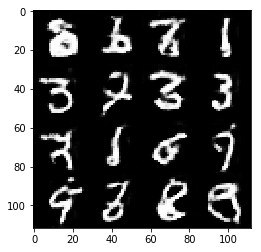

Epoch 2/2... Discriminator Loss: 2.0608... Generator Loss: 0.1642
Epoch 2/2... Discriminator Loss: 1.6107... Generator Loss: 0.5549
Epoch 2/2... Discriminator Loss: 1.7180... Generator Loss: 0.4479
Epoch 2/2... Discriminator Loss: 1.8004... Generator Loss: 0.2849
Epoch 2/2... Discriminator Loss: 1.9139... Generator Loss: 0.3024
Epoch 2/2... Discriminator Loss: 1.8248... Generator Loss: 0.2413
Epoch 2/2... Discriminator Loss: 2.0963... Generator Loss: 1.3849
Epoch 2/2... Discriminator Loss: 2.0954... Generator Loss: 0.1742
Epoch 2/2... Discriminator Loss: 1.9859... Generator Loss: 0.1888
Epoch 2/2... Discriminator Loss: 2.1975... Generator Loss: 0.1398


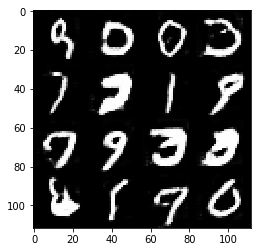

Epoch 2/2... Discriminator Loss: 1.8977... Generator Loss: 0.2414
Epoch 2/2... Discriminator Loss: 1.8391... Generator Loss: 0.3191
Epoch 2/2... Discriminator Loss: 2.2959... Generator Loss: 0.1176
Epoch 2/2... Discriminator Loss: 2.3977... Generator Loss: 0.1046
Epoch 2/2... Discriminator Loss: 1.9716... Generator Loss: 0.2169
Epoch 2/2... Discriminator Loss: 1.9523... Generator Loss: 0.2010
Epoch 2/2... Discriminator Loss: 1.9496... Generator Loss: 0.2155
Epoch 2/2... Discriminator Loss: 1.9896... Generator Loss: 0.4713
Epoch 2/2... Discriminator Loss: 1.7110... Generator Loss: 0.3633
Epoch 2/2... Discriminator Loss: 1.8312... Generator Loss: 0.2416


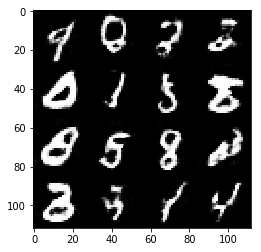

Epoch 2/2... Discriminator Loss: 2.1990... Generator Loss: 0.1330
Epoch 2/2... Discriminator Loss: 1.9129... Generator Loss: 0.2044
Epoch 2/2... Discriminator Loss: 1.6338... Generator Loss: 0.3596
Epoch 2/2... Discriminator Loss: 1.9572... Generator Loss: 0.1871
Epoch 2/2... Discriminator Loss: 2.0424... Generator Loss: 0.1806
Epoch 2/2... Discriminator Loss: 2.3076... Generator Loss: 1.2896
Epoch 2/2... Discriminator Loss: 1.8823... Generator Loss: 0.2139


In [97]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1

#tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 6.2151... Generator Loss: 0.0023
Epoch 1/1... Discriminator Loss: 12.5755... Generator Loss: 0.0002
Epoch 1/1... Discriminator Loss: 8.2702... Generator Loss: 0.0006
Epoch 1/1... Discriminator Loss: 6.5173... Generator Loss: 0.0017
Epoch 1/1... Discriminator Loss: 5.3437... Generator Loss: 0.0067
Epoch 1/1... Discriminator Loss: 4.7601... Generator Loss: 0.0104
Epoch 1/1... Discriminator Loss: 4.7281... Generator Loss: 0.0164
Epoch 1/1... Discriminator Loss: 5.8376... Generator Loss: 0.0036
Epoch 1/1... Discriminator Loss: 8.2886... Generator Loss: 0.0003
Epoch 1/1... Discriminator Loss: 5.4288... Generator Loss: 0.0049


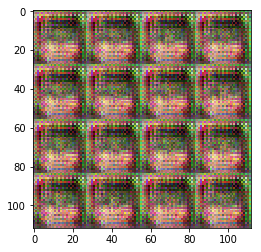

Epoch 1/1... Discriminator Loss: 4.9439... Generator Loss: 0.0083
Epoch 1/1... Discriminator Loss: 4.5985... Generator Loss: 0.0128
Epoch 1/1... Discriminator Loss: 3.5966... Generator Loss: 0.0325
Epoch 1/1... Discriminator Loss: 3.3540... Generator Loss: 0.0765
Epoch 1/1... Discriminator Loss: 3.8569... Generator Loss: 0.0240
Epoch 1/1... Discriminator Loss: 4.6519... Generator Loss: 0.0110
Epoch 1/1... Discriminator Loss: 2.6949... Generator Loss: 0.0939
Epoch 1/1... Discriminator Loss: 3.8003... Generator Loss: 0.0248
Epoch 1/1... Discriminator Loss: 1.7663... Generator Loss: 0.3561
Epoch 1/1... Discriminator Loss: 3.0997... Generator Loss: 0.0527


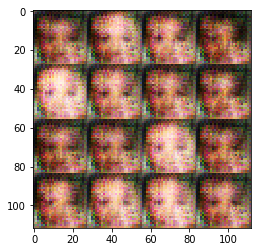

Epoch 1/1... Discriminator Loss: 3.2439... Generator Loss: 0.0420
Epoch 1/1... Discriminator Loss: 4.4699... Generator Loss: 0.0140
Epoch 1/1... Discriminator Loss: 3.5796... Generator Loss: 0.0322
Epoch 1/1... Discriminator Loss: 2.6497... Generator Loss: 0.1483
Epoch 1/1... Discriminator Loss: 3.0232... Generator Loss: 0.0561
Epoch 1/1... Discriminator Loss: 3.3112... Generator Loss: 0.0429
Epoch 1/1... Discriminator Loss: 3.5733... Generator Loss: 0.0532
Epoch 1/1... Discriminator Loss: 3.7000... Generator Loss: 0.0588
Epoch 1/1... Discriminator Loss: 3.8140... Generator Loss: 0.0258
Epoch 1/1... Discriminator Loss: 3.8274... Generator Loss: 0.0257


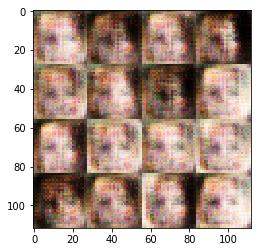

Epoch 1/1... Discriminator Loss: 3.2924... Generator Loss: 0.0512
Epoch 1/1... Discriminator Loss: 3.8331... Generator Loss: 0.0243
Epoch 1/1... Discriminator Loss: 3.8592... Generator Loss: 0.0329
Epoch 1/1... Discriminator Loss: 3.1207... Generator Loss: 0.0678
Epoch 1/1... Discriminator Loss: 2.9993... Generator Loss: 0.0543
Epoch 1/1... Discriminator Loss: 3.6338... Generator Loss: 0.0329
Epoch 1/1... Discriminator Loss: 2.8769... Generator Loss: 0.0700
Epoch 1/1... Discriminator Loss: 2.8171... Generator Loss: 0.0730
Epoch 1/1... Discriminator Loss: 3.5227... Generator Loss: 0.0344
Epoch 1/1... Discriminator Loss: 3.2043... Generator Loss: 0.0589


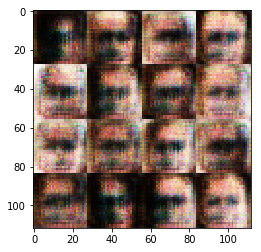

Epoch 1/1... Discriminator Loss: 3.0266... Generator Loss: 0.0836
Epoch 1/1... Discriminator Loss: 2.7876... Generator Loss: 0.0727
Epoch 1/1... Discriminator Loss: 3.2368... Generator Loss: 0.0622
Epoch 1/1... Discriminator Loss: 3.3838... Generator Loss: 0.0505
Epoch 1/1... Discriminator Loss: 3.3307... Generator Loss: 0.0492
Epoch 1/1... Discriminator Loss: 2.6058... Generator Loss: 0.0909
Epoch 1/1... Discriminator Loss: 3.1113... Generator Loss: 0.0691
Epoch 1/1... Discriminator Loss: 2.7992... Generator Loss: 0.0748
Epoch 1/1... Discriminator Loss: 3.4435... Generator Loss: 0.0353
Epoch 1/1... Discriminator Loss: 3.0541... Generator Loss: 0.0709


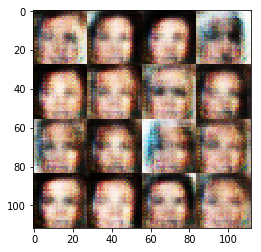

Epoch 1/1... Discriminator Loss: 2.9571... Generator Loss: 0.1011
Epoch 1/1... Discriminator Loss: 2.8915... Generator Loss: 0.0741
Epoch 1/1... Discriminator Loss: 2.7342... Generator Loss: 0.0818
Epoch 1/1... Discriminator Loss: 2.9778... Generator Loss: 0.0565
Epoch 1/1... Discriminator Loss: 3.1479... Generator Loss: 0.0639
Epoch 1/1... Discriminator Loss: 3.4594... Generator Loss: 0.0464
Epoch 1/1... Discriminator Loss: 3.5799... Generator Loss: 0.0379
Epoch 1/1... Discriminator Loss: 2.8465... Generator Loss: 0.0847
Epoch 1/1... Discriminator Loss: 2.5833... Generator Loss: 0.1028
Epoch 1/1... Discriminator Loss: 2.5501... Generator Loss: 0.1255


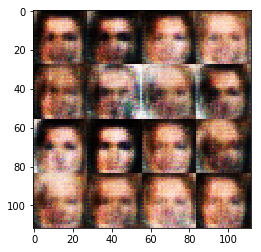

Epoch 1/1... Discriminator Loss: 2.8098... Generator Loss: 0.0981
Epoch 1/1... Discriminator Loss: 2.9378... Generator Loss: 0.0664
Epoch 1/1... Discriminator Loss: 3.7133... Generator Loss: 0.0373
Epoch 1/1... Discriminator Loss: 3.3794... Generator Loss: 0.0496
Epoch 1/1... Discriminator Loss: 2.3756... Generator Loss: 0.1370
Epoch 1/1... Discriminator Loss: 2.6242... Generator Loss: 0.0938
Epoch 1/1... Discriminator Loss: 2.8023... Generator Loss: 0.0900
Epoch 1/1... Discriminator Loss: 2.8136... Generator Loss: 0.0893
Epoch 1/1... Discriminator Loss: 2.8000... Generator Loss: 0.0724
Epoch 1/1... Discriminator Loss: 3.0392... Generator Loss: 0.0575


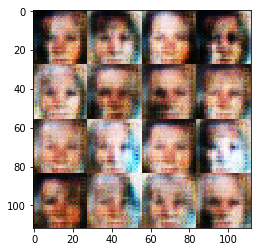

Epoch 1/1... Discriminator Loss: 2.7187... Generator Loss: 0.0831
Epoch 1/1... Discriminator Loss: 3.1116... Generator Loss: 0.0568
Epoch 1/1... Discriminator Loss: 2.5479... Generator Loss: 0.1076
Epoch 1/1... Discriminator Loss: 3.0731... Generator Loss: 0.0622
Epoch 1/1... Discriminator Loss: 2.6632... Generator Loss: 0.0948
Epoch 1/1... Discriminator Loss: 2.9279... Generator Loss: 0.0788
Epoch 1/1... Discriminator Loss: 2.9038... Generator Loss: 0.0706
Epoch 1/1... Discriminator Loss: 3.4523... Generator Loss: 0.0570
Epoch 1/1... Discriminator Loss: 2.5131... Generator Loss: 0.1146
Epoch 1/1... Discriminator Loss: 2.7115... Generator Loss: 0.0794


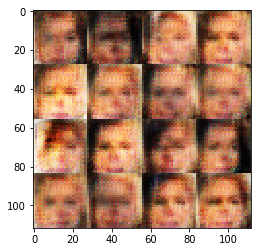

Epoch 1/1... Discriminator Loss: 2.3090... Generator Loss: 0.1348
Epoch 1/1... Discriminator Loss: 2.2465... Generator Loss: 0.1543
Epoch 1/1... Discriminator Loss: 2.5342... Generator Loss: 0.1189
Epoch 1/1... Discriminator Loss: 2.8030... Generator Loss: 0.1205
Epoch 1/1... Discriminator Loss: 2.6374... Generator Loss: 0.0933
Epoch 1/1... Discriminator Loss: 3.1380... Generator Loss: 0.0506
Epoch 1/1... Discriminator Loss: 2.9774... Generator Loss: 0.0731
Epoch 1/1... Discriminator Loss: 2.7830... Generator Loss: 0.0850
Epoch 1/1... Discriminator Loss: 2.3804... Generator Loss: 0.1361
Epoch 1/1... Discriminator Loss: 2.5812... Generator Loss: 0.1378


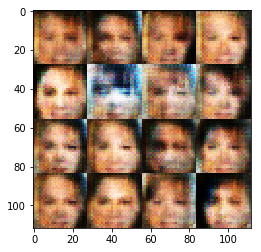

Epoch 1/1... Discriminator Loss: 2.7019... Generator Loss: 0.0945
Epoch 1/1... Discriminator Loss: 2.7266... Generator Loss: 0.1054
Epoch 1/1... Discriminator Loss: 2.7863... Generator Loss: 0.0768
Epoch 1/1... Discriminator Loss: 3.1169... Generator Loss: 0.0828
Epoch 1/1... Discriminator Loss: 3.2143... Generator Loss: 0.0551
Epoch 1/1... Discriminator Loss: 3.1463... Generator Loss: 0.0678
Epoch 1/1... Discriminator Loss: 3.3130... Generator Loss: 0.0553
Epoch 1/1... Discriminator Loss: 2.8787... Generator Loss: 0.0925
Epoch 1/1... Discriminator Loss: 2.7273... Generator Loss: 0.0773
Epoch 1/1... Discriminator Loss: 2.9268... Generator Loss: 0.0633


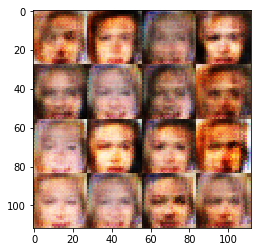

Epoch 1/1... Discriminator Loss: 2.9764... Generator Loss: 0.0729
Epoch 1/1... Discriminator Loss: 3.1237... Generator Loss: 0.0963
Epoch 1/1... Discriminator Loss: 2.8889... Generator Loss: 0.0742
Epoch 1/1... Discriminator Loss: 2.5792... Generator Loss: 0.0993
Epoch 1/1... Discriminator Loss: 2.6836... Generator Loss: 0.1065
Epoch 1/1... Discriminator Loss: 2.7111... Generator Loss: 0.0978
Epoch 1/1... Discriminator Loss: 3.2324... Generator Loss: 0.0488
Epoch 1/1... Discriminator Loss: 2.8994... Generator Loss: 0.0679
Epoch 1/1... Discriminator Loss: 3.0185... Generator Loss: 0.0810
Epoch 1/1... Discriminator Loss: 2.7174... Generator Loss: 0.0878


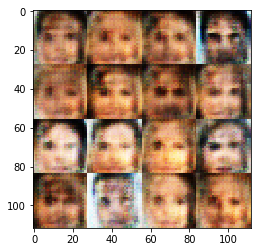

Epoch 1/1... Discriminator Loss: 2.7233... Generator Loss: 0.0809
Epoch 1/1... Discriminator Loss: 3.0997... Generator Loss: 0.1043
Epoch 1/1... Discriminator Loss: 2.6833... Generator Loss: 0.0850
Epoch 1/1... Discriminator Loss: 2.7882... Generator Loss: 0.1108
Epoch 1/1... Discriminator Loss: 2.6315... Generator Loss: 0.1593
Epoch 1/1... Discriminator Loss: 3.2181... Generator Loss: 0.0738
Epoch 1/1... Discriminator Loss: 2.6687... Generator Loss: 0.1235
Epoch 1/1... Discriminator Loss: 2.4717... Generator Loss: 0.1240
Epoch 1/1... Discriminator Loss: 3.0932... Generator Loss: 0.0702
Epoch 1/1... Discriminator Loss: 2.2589... Generator Loss: 0.1519


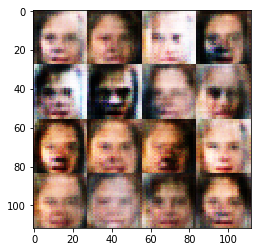

Epoch 1/1... Discriminator Loss: 2.6923... Generator Loss: 0.0896
Epoch 1/1... Discriminator Loss: 2.9136... Generator Loss: 0.0801
Epoch 1/1... Discriminator Loss: 2.5596... Generator Loss: 0.1414
Epoch 1/1... Discriminator Loss: 2.3852... Generator Loss: 0.1613
Epoch 1/1... Discriminator Loss: 2.4051... Generator Loss: 0.1272
Epoch 1/1... Discriminator Loss: 2.4932... Generator Loss: 0.1612
Epoch 1/1... Discriminator Loss: 2.4397... Generator Loss: 0.1958
Epoch 1/1... Discriminator Loss: 2.4956... Generator Loss: 0.1306
Epoch 1/1... Discriminator Loss: 2.8139... Generator Loss: 0.0918
Epoch 1/1... Discriminator Loss: 2.9205... Generator Loss: 0.0796


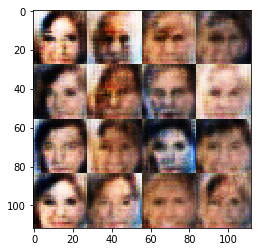

Epoch 1/1... Discriminator Loss: 2.4620... Generator Loss: 0.1175
Epoch 1/1... Discriminator Loss: 2.6226... Generator Loss: 0.0938
Epoch 1/1... Discriminator Loss: 2.6411... Generator Loss: 0.1458
Epoch 1/1... Discriminator Loss: 2.5473... Generator Loss: 0.1089
Epoch 1/1... Discriminator Loss: 2.6819... Generator Loss: 0.1191
Epoch 1/1... Discriminator Loss: 2.9363... Generator Loss: 0.0948
Epoch 1/1... Discriminator Loss: 2.5074... Generator Loss: 0.1093
Epoch 1/1... Discriminator Loss: 2.9144... Generator Loss: 0.0825
Epoch 1/1... Discriminator Loss: 2.8220... Generator Loss: 0.1189
Epoch 1/1... Discriminator Loss: 2.5598... Generator Loss: 0.1060


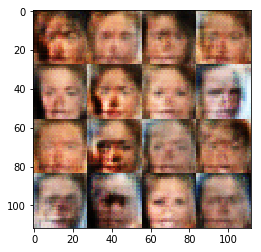

Epoch 1/1... Discriminator Loss: 3.2182... Generator Loss: 0.0621
Epoch 1/1... Discriminator Loss: 2.6838... Generator Loss: 0.1159
Epoch 1/1... Discriminator Loss: 2.7759... Generator Loss: 0.1205
Epoch 1/1... Discriminator Loss: 3.1096... Generator Loss: 0.0900
Epoch 1/1... Discriminator Loss: 2.5600... Generator Loss: 0.1195
Epoch 1/1... Discriminator Loss: 2.5719... Generator Loss: 0.1231
Epoch 1/1... Discriminator Loss: 2.3996... Generator Loss: 0.1292
Epoch 1/1... Discriminator Loss: 2.4748... Generator Loss: 0.1218
Epoch 1/1... Discriminator Loss: 2.8529... Generator Loss: 0.0772
Epoch 1/1... Discriminator Loss: 2.4794... Generator Loss: 0.1275


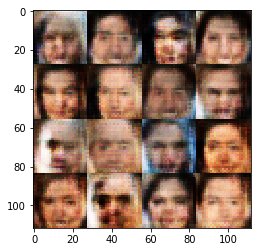

Epoch 1/1... Discriminator Loss: 2.8968... Generator Loss: 0.1000
Epoch 1/1... Discriminator Loss: 2.8266... Generator Loss: 0.0814
Epoch 1/1... Discriminator Loss: 2.7846... Generator Loss: 0.0910
Epoch 1/1... Discriminator Loss: 2.5406... Generator Loss: 0.1383
Epoch 1/1... Discriminator Loss: 2.6066... Generator Loss: 0.1097
Epoch 1/1... Discriminator Loss: 2.8170... Generator Loss: 0.0896
Epoch 1/1... Discriminator Loss: 2.3659... Generator Loss: 0.1510
Epoch 1/1... Discriminator Loss: 2.9322... Generator Loss: 0.1127
Epoch 1/1... Discriminator Loss: 2.1219... Generator Loss: 0.2040
Epoch 1/1... Discriminator Loss: 2.4706... Generator Loss: 0.1396


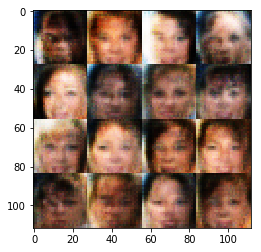

Epoch 1/1... Discriminator Loss: 2.6039... Generator Loss: 0.1027
Epoch 1/1... Discriminator Loss: 3.0826... Generator Loss: 0.0982
Epoch 1/1... Discriminator Loss: 2.6290... Generator Loss: 0.1061
Epoch 1/1... Discriminator Loss: 2.6838... Generator Loss: 0.1201
Epoch 1/1... Discriminator Loss: 2.7962... Generator Loss: 0.0948
Epoch 1/1... Discriminator Loss: 2.7368... Generator Loss: 0.0985
Epoch 1/1... Discriminator Loss: 2.4866... Generator Loss: 0.1109
Epoch 1/1... Discriminator Loss: 2.7500... Generator Loss: 0.1327
Epoch 1/1... Discriminator Loss: 2.7129... Generator Loss: 0.1051
Epoch 1/1... Discriminator Loss: 2.5045... Generator Loss: 0.1374


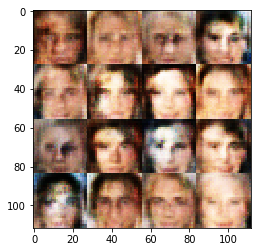

Epoch 1/1... Discriminator Loss: 2.1276... Generator Loss: 0.2104
Epoch 1/1... Discriminator Loss: 2.6687... Generator Loss: 0.1141
Epoch 1/1... Discriminator Loss: 2.6212... Generator Loss: 0.1348
Epoch 1/1... Discriminator Loss: 2.5298... Generator Loss: 0.1233
Epoch 1/1... Discriminator Loss: 2.3043... Generator Loss: 0.1475
Epoch 1/1... Discriminator Loss: 2.7480... Generator Loss: 0.1516
Epoch 1/1... Discriminator Loss: 2.8954... Generator Loss: 0.1179
Epoch 1/1... Discriminator Loss: 3.0070... Generator Loss: 0.1036
Epoch 1/1... Discriminator Loss: 2.8786... Generator Loss: 0.0920
Epoch 1/1... Discriminator Loss: 2.8676... Generator Loss: 0.1041


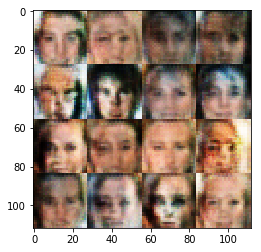

Epoch 1/1... Discriminator Loss: 2.1717... Generator Loss: 0.1800
Epoch 1/1... Discriminator Loss: 2.5999... Generator Loss: 0.1337
Epoch 1/1... Discriminator Loss: 2.5456... Generator Loss: 0.1371
Epoch 1/1... Discriminator Loss: 2.9769... Generator Loss: 0.1224
Epoch 1/1... Discriminator Loss: 2.4498... Generator Loss: 0.1283
Epoch 1/1... Discriminator Loss: 2.7139... Generator Loss: 0.1148
Epoch 1/1... Discriminator Loss: 2.7818... Generator Loss: 0.1121
Epoch 1/1... Discriminator Loss: 3.1884... Generator Loss: 0.0937
Epoch 1/1... Discriminator Loss: 2.5860... Generator Loss: 0.1051
Epoch 1/1... Discriminator Loss: 3.2377... Generator Loss: 0.0608


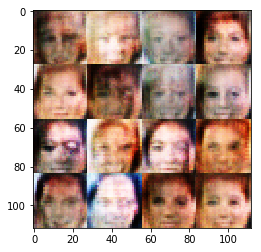

Epoch 1/1... Discriminator Loss: 2.3114... Generator Loss: 0.1559
Epoch 1/1... Discriminator Loss: 2.5125... Generator Loss: 0.1680
Epoch 1/1... Discriminator Loss: 2.4860... Generator Loss: 0.1388
Epoch 1/1... Discriminator Loss: 2.6796... Generator Loss: 0.1341
Epoch 1/1... Discriminator Loss: 2.1276... Generator Loss: 0.1954
Epoch 1/1... Discriminator Loss: 2.6618... Generator Loss: 0.1075
Epoch 1/1... Discriminator Loss: 2.6964... Generator Loss: 0.1362
Epoch 1/1... Discriminator Loss: 2.4383... Generator Loss: 0.1505
Epoch 1/1... Discriminator Loss: 2.6512... Generator Loss: 0.1124
Epoch 1/1... Discriminator Loss: 2.4416... Generator Loss: 0.1273


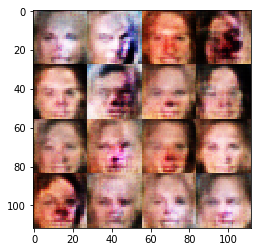

Epoch 1/1... Discriminator Loss: 2.8216... Generator Loss: 0.1171
Epoch 1/1... Discriminator Loss: 2.2238... Generator Loss: 0.1993
Epoch 1/1... Discriminator Loss: 2.7702... Generator Loss: 0.0995
Epoch 1/1... Discriminator Loss: 2.4760... Generator Loss: 0.1203
Epoch 1/1... Discriminator Loss: 2.8348... Generator Loss: 0.1072
Epoch 1/1... Discriminator Loss: 2.6795... Generator Loss: 0.1012
Epoch 1/1... Discriminator Loss: 2.8332... Generator Loss: 0.1213
Epoch 1/1... Discriminator Loss: 2.8430... Generator Loss: 0.1079
Epoch 1/1... Discriminator Loss: 2.4042... Generator Loss: 0.1467
Epoch 1/1... Discriminator Loss: 2.5407... Generator Loss: 0.1045


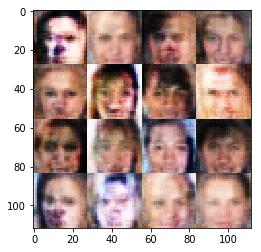

Epoch 1/1... Discriminator Loss: 2.6530... Generator Loss: 0.1235
Epoch 1/1... Discriminator Loss: 2.8724... Generator Loss: 0.0923
Epoch 1/1... Discriminator Loss: 2.6382... Generator Loss: 0.1407
Epoch 1/1... Discriminator Loss: 2.9292... Generator Loss: 0.1207
Epoch 1/1... Discriminator Loss: 2.8545... Generator Loss: 0.1009
Epoch 1/1... Discriminator Loss: 2.6896... Generator Loss: 0.1450
Epoch 1/1... Discriminator Loss: 3.2039... Generator Loss: 0.0886
Epoch 1/1... Discriminator Loss: 3.1177... Generator Loss: 0.0900
Epoch 1/1... Discriminator Loss: 2.4701... Generator Loss: 0.1251
Epoch 1/1... Discriminator Loss: 2.4937... Generator Loss: 0.1571


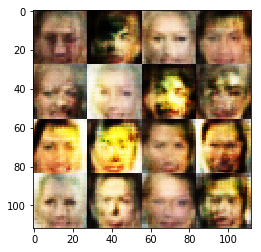

Epoch 1/1... Discriminator Loss: 3.2341... Generator Loss: 0.0719
Epoch 1/1... Discriminator Loss: 3.1069... Generator Loss: 0.0879
Epoch 1/1... Discriminator Loss: 2.2913... Generator Loss: 0.1439
Epoch 1/1... Discriminator Loss: 2.9869... Generator Loss: 0.0791
Epoch 1/1... Discriminator Loss: 2.7458... Generator Loss: 0.1210
Epoch 1/1... Discriminator Loss: 2.6752... Generator Loss: 0.1317
Epoch 1/1... Discriminator Loss: 2.8334... Generator Loss: 0.1000
Epoch 1/1... Discriminator Loss: 2.7527... Generator Loss: 0.0972
Epoch 1/1... Discriminator Loss: 2.2438... Generator Loss: 0.2099
Epoch 1/1... Discriminator Loss: 2.5624... Generator Loss: 0.1126


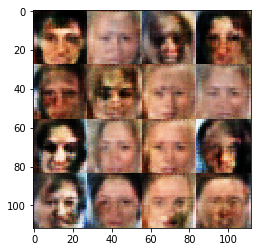

Epoch 1/1... Discriminator Loss: 2.4551... Generator Loss: 0.1237
Epoch 1/1... Discriminator Loss: 2.5143... Generator Loss: 0.1319
Epoch 1/1... Discriminator Loss: 2.3666... Generator Loss: 0.1401
Epoch 1/1... Discriminator Loss: 3.3097... Generator Loss: 0.1165
Epoch 1/1... Discriminator Loss: 2.2141... Generator Loss: 0.1551
Epoch 1/1... Discriminator Loss: 2.3330... Generator Loss: 0.1575
Epoch 1/1... Discriminator Loss: 2.6724... Generator Loss: 0.1606
Epoch 1/1... Discriminator Loss: 2.5073... Generator Loss: 0.1340
Epoch 1/1... Discriminator Loss: 2.9274... Generator Loss: 0.0808
Epoch 1/1... Discriminator Loss: 2.4270... Generator Loss: 0.1976


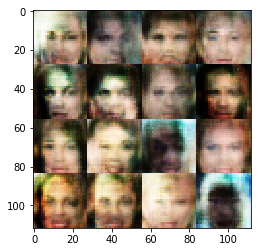

Epoch 1/1... Discriminator Loss: 2.6313... Generator Loss: 0.1317
Epoch 1/1... Discriminator Loss: 2.8245... Generator Loss: 0.0892
Epoch 1/1... Discriminator Loss: 2.8248... Generator Loss: 0.1068
Epoch 1/1... Discriminator Loss: 2.4637... Generator Loss: 0.1125
Epoch 1/1... Discriminator Loss: 2.6179... Generator Loss: 0.0922
Epoch 1/1... Discriminator Loss: 2.6445... Generator Loss: 0.1062
Epoch 1/1... Discriminator Loss: 2.8391... Generator Loss: 0.0953
Epoch 1/1... Discriminator Loss: 2.3984... Generator Loss: 0.1530
Epoch 1/1... Discriminator Loss: 3.0885... Generator Loss: 0.1175
Epoch 1/1... Discriminator Loss: 2.7547... Generator Loss: 0.0910


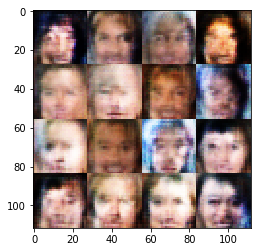

Epoch 1/1... Discriminator Loss: 2.9161... Generator Loss: 0.1534
Epoch 1/1... Discriminator Loss: 2.7446... Generator Loss: 0.0883
Epoch 1/1... Discriminator Loss: 2.3260... Generator Loss: 0.1677
Epoch 1/1... Discriminator Loss: 2.6023... Generator Loss: 0.1047
Epoch 1/1... Discriminator Loss: 3.0137... Generator Loss: 0.0964
Epoch 1/1... Discriminator Loss: 2.6915... Generator Loss: 0.1412
Epoch 1/1... Discriminator Loss: 2.4288... Generator Loss: 0.1540
Epoch 1/1... Discriminator Loss: 2.4293... Generator Loss: 0.1602
Epoch 1/1... Discriminator Loss: 2.5566... Generator Loss: 0.1370
Epoch 1/1... Discriminator Loss: 2.7554... Generator Loss: 0.1069


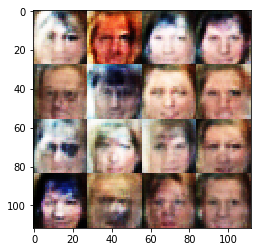

Epoch 1/1... Discriminator Loss: 2.4560... Generator Loss: 0.1253
Epoch 1/1... Discriminator Loss: 2.6481... Generator Loss: 0.1565
Epoch 1/1... Discriminator Loss: 2.8614... Generator Loss: 0.1064
Epoch 1/1... Discriminator Loss: 3.0362... Generator Loss: 0.1389
Epoch 1/1... Discriminator Loss: 2.3804... Generator Loss: 0.1593
Epoch 1/1... Discriminator Loss: 2.7701... Generator Loss: 0.0995
Epoch 1/1... Discriminator Loss: 2.6279... Generator Loss: 0.1427
Epoch 1/1... Discriminator Loss: 2.4559... Generator Loss: 0.1619
Epoch 1/1... Discriminator Loss: 3.0060... Generator Loss: 0.0797
Epoch 1/1... Discriminator Loss: 2.6676... Generator Loss: 0.1060


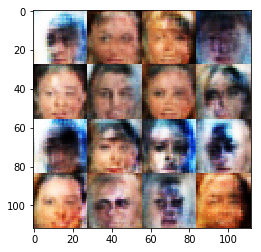

Epoch 1/1... Discriminator Loss: 2.6621... Generator Loss: 0.0922
Epoch 1/1... Discriminator Loss: 2.1013... Generator Loss: 0.1957
Epoch 1/1... Discriminator Loss: 2.3863... Generator Loss: 0.1464
Epoch 1/1... Discriminator Loss: 2.8376... Generator Loss: 0.1471
Epoch 1/1... Discriminator Loss: 2.5796... Generator Loss: 0.1012
Epoch 1/1... Discriminator Loss: 2.8566... Generator Loss: 0.0878
Epoch 1/1... Discriminator Loss: 2.5191... Generator Loss: 0.1269
Epoch 1/1... Discriminator Loss: 3.2054... Generator Loss: 0.0747
Epoch 1/1... Discriminator Loss: 2.6089... Generator Loss: 0.1335
Epoch 1/1... Discriminator Loss: 2.4965... Generator Loss: 0.1156


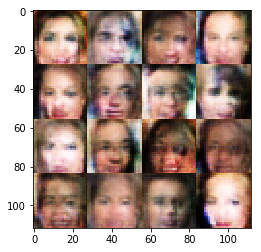

Epoch 1/1... Discriminator Loss: 2.8076... Generator Loss: 0.0973
Epoch 1/1... Discriminator Loss: 2.8306... Generator Loss: 0.1062
Epoch 1/1... Discriminator Loss: 3.1975... Generator Loss: 0.0985
Epoch 1/1... Discriminator Loss: 2.7673... Generator Loss: 0.1200
Epoch 1/1... Discriminator Loss: 2.3365... Generator Loss: 0.1425
Epoch 1/1... Discriminator Loss: 2.5567... Generator Loss: 0.1342
Epoch 1/1... Discriminator Loss: 2.2904... Generator Loss: 0.1881
Epoch 1/1... Discriminator Loss: 2.5592... Generator Loss: 0.1434
Epoch 1/1... Discriminator Loss: 2.4253... Generator Loss: 0.1710
Epoch 1/1... Discriminator Loss: 2.7573... Generator Loss: 0.1049


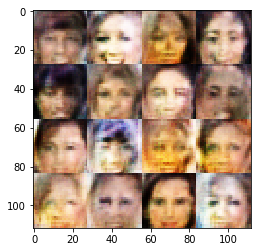

Epoch 1/1... Discriminator Loss: 2.5001... Generator Loss: 0.1619
Epoch 1/1... Discriminator Loss: 2.6073... Generator Loss: 0.1035
Epoch 1/1... Discriminator Loss: 2.8069... Generator Loss: 0.0991
Epoch 1/1... Discriminator Loss: 2.8085... Generator Loss: 0.0916
Epoch 1/1... Discriminator Loss: 2.8938... Generator Loss: 0.1165
Epoch 1/1... Discriminator Loss: 3.0427... Generator Loss: 0.0846
Epoch 1/1... Discriminator Loss: 2.8149... Generator Loss: 0.1213
Epoch 1/1... Discriminator Loss: 2.6306... Generator Loss: 0.1566
Epoch 1/1... Discriminator Loss: 2.6184... Generator Loss: 0.1248
Epoch 1/1... Discriminator Loss: 2.4683... Generator Loss: 0.1083


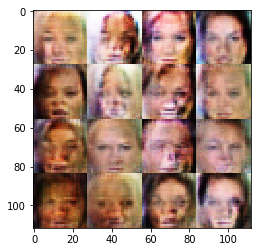

Epoch 1/1... Discriminator Loss: 2.4714... Generator Loss: 0.1070
Epoch 1/1... Discriminator Loss: 2.6290... Generator Loss: 0.0982
Epoch 1/1... Discriminator Loss: 2.5491... Generator Loss: 0.1448
Epoch 1/1... Discriminator Loss: 2.6854... Generator Loss: 0.0884
Epoch 1/1... Discriminator Loss: 2.3360... Generator Loss: 0.1569
Epoch 1/1... Discriminator Loss: 2.8026... Generator Loss: 0.0762
Epoch 1/1... Discriminator Loss: 2.5810... Generator Loss: 0.1490
Epoch 1/1... Discriminator Loss: 2.5826... Generator Loss: 0.1215
Epoch 1/1... Discriminator Loss: 2.4440... Generator Loss: 0.1418
Epoch 1/1... Discriminator Loss: 2.6983... Generator Loss: 0.1460


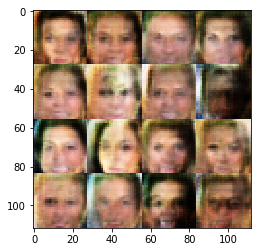

Epoch 1/1... Discriminator Loss: 2.5403... Generator Loss: 0.1079
Epoch 1/1... Discriminator Loss: 2.8767... Generator Loss: 0.0857
Epoch 1/1... Discriminator Loss: 2.6558... Generator Loss: 0.1206
Epoch 1/1... Discriminator Loss: 2.5014... Generator Loss: 0.1160
Epoch 1/1... Discriminator Loss: 2.5646... Generator Loss: 0.1053
Epoch 1/1... Discriminator Loss: 2.6673... Generator Loss: 0.1161
Epoch 1/1... Discriminator Loss: 2.9107... Generator Loss: 0.1017
Epoch 1/1... Discriminator Loss: 2.8671... Generator Loss: 0.0960
Epoch 1/1... Discriminator Loss: 2.9648... Generator Loss: 0.1147
Epoch 1/1... Discriminator Loss: 2.3900... Generator Loss: 0.1355


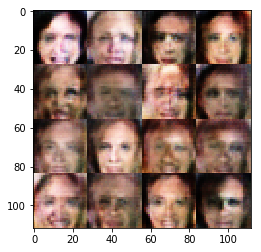

Epoch 1/1... Discriminator Loss: 2.6742... Generator Loss: 0.1729
Epoch 1/1... Discriminator Loss: 2.9714... Generator Loss: 0.1287
Epoch 1/1... Discriminator Loss: 2.3510... Generator Loss: 0.1560
Epoch 1/1... Discriminator Loss: 2.7830... Generator Loss: 0.0735
Epoch 1/1... Discriminator Loss: 2.8964... Generator Loss: 0.0720
Epoch 1/1... Discriminator Loss: 2.4676... Generator Loss: 0.1411
Epoch 1/1... Discriminator Loss: 2.7154... Generator Loss: 0.0985
Epoch 1/1... Discriminator Loss: 2.6939... Generator Loss: 0.1610
Epoch 1/1... Discriminator Loss: 2.8765... Generator Loss: 0.1340
Epoch 1/1... Discriminator Loss: 2.9222... Generator Loss: 0.0759


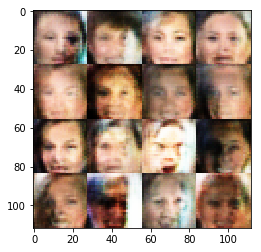

Epoch 1/1... Discriminator Loss: 2.8245... Generator Loss: 0.0752
Epoch 1/1... Discriminator Loss: 2.4455... Generator Loss: 0.1277
Epoch 1/1... Discriminator Loss: 2.4518... Generator Loss: 0.1658
Epoch 1/1... Discriminator Loss: 3.0024... Generator Loss: 0.0758
Epoch 1/1... Discriminator Loss: 2.8338... Generator Loss: 0.1447
Epoch 1/1... Discriminator Loss: 2.4493... Generator Loss: 0.1442
Epoch 1/1... Discriminator Loss: 2.6430... Generator Loss: 0.0934
Epoch 1/1... Discriminator Loss: 2.6242... Generator Loss: 0.1105
Epoch 1/1... Discriminator Loss: 2.8598... Generator Loss: 0.0929
Epoch 1/1... Discriminator Loss: 2.7855... Generator Loss: 0.1064


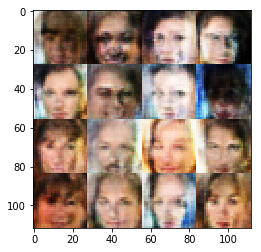

Epoch 1/1... Discriminator Loss: 2.5913... Generator Loss: 0.1542
Epoch 1/1... Discriminator Loss: 2.9557... Generator Loss: 0.0900
Epoch 1/1... Discriminator Loss: 2.7914... Generator Loss: 0.1071
Epoch 1/1... Discriminator Loss: 2.8809... Generator Loss: 0.1107
Epoch 1/1... Discriminator Loss: 2.6472... Generator Loss: 0.0911
Epoch 1/1... Discriminator Loss: 2.4693... Generator Loss: 0.1462
Epoch 1/1... Discriminator Loss: 2.1640... Generator Loss: 0.1722
Epoch 1/1... Discriminator Loss: 2.9424... Generator Loss: 0.1601
Epoch 1/1... Discriminator Loss: 2.6265... Generator Loss: 0.0998
Epoch 1/1... Discriminator Loss: 2.7505... Generator Loss: 0.1090


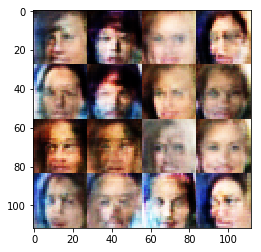

Epoch 1/1... Discriminator Loss: 2.4933... Generator Loss: 0.1294
Epoch 1/1... Discriminator Loss: 2.4102... Generator Loss: 0.1456
Epoch 1/1... Discriminator Loss: 2.9527... Generator Loss: 0.0716
Epoch 1/1... Discriminator Loss: 2.5682... Generator Loss: 0.1098
Epoch 1/1... Discriminator Loss: 2.5099... Generator Loss: 0.1704
Epoch 1/1... Discriminator Loss: 2.9233... Generator Loss: 0.0675
Epoch 1/1... Discriminator Loss: 2.4532... Generator Loss: 0.1327
Epoch 1/1... Discriminator Loss: 2.8006... Generator Loss: 0.0868
Epoch 1/1... Discriminator Loss: 2.7586... Generator Loss: 0.1512
Epoch 1/1... Discriminator Loss: 2.2775... Generator Loss: 0.1846


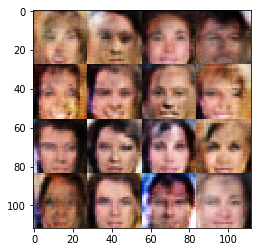

Epoch 1/1... Discriminator Loss: 2.2087... Generator Loss: 0.1847
Epoch 1/1... Discriminator Loss: 2.3854... Generator Loss: 0.1633
Epoch 1/1... Discriminator Loss: 2.1510... Generator Loss: 0.1872
Epoch 1/1... Discriminator Loss: 2.4822... Generator Loss: 0.1399
Epoch 1/1... Discriminator Loss: 2.7149... Generator Loss: 0.1709
Epoch 1/1... Discriminator Loss: 2.7037... Generator Loss: 0.1427
Epoch 1/1... Discriminator Loss: 2.2278... Generator Loss: 0.1706
Epoch 1/1... Discriminator Loss: 2.3087... Generator Loss: 0.1565
Epoch 1/1... Discriminator Loss: 2.7460... Generator Loss: 0.1438
Epoch 1/1... Discriminator Loss: 2.5556... Generator Loss: 0.1133


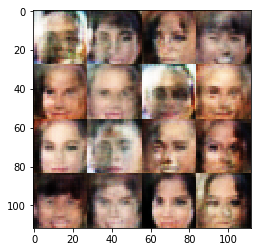

Epoch 1/1... Discriminator Loss: 2.7196... Generator Loss: 0.1070
Epoch 1/1... Discriminator Loss: 2.9856... Generator Loss: 0.0905
Epoch 1/1... Discriminator Loss: 2.3292... Generator Loss: 0.1471
Epoch 1/1... Discriminator Loss: 2.6783... Generator Loss: 0.1700
Epoch 1/1... Discriminator Loss: 2.5456... Generator Loss: 0.1064
Epoch 1/1... Discriminator Loss: 2.6566... Generator Loss: 0.0885
Epoch 1/1... Discriminator Loss: 2.8191... Generator Loss: 0.1223
Epoch 1/1... Discriminator Loss: 2.2654... Generator Loss: 0.1364
Epoch 1/1... Discriminator Loss: 2.5339... Generator Loss: 0.1080
Epoch 1/1... Discriminator Loss: 2.7324... Generator Loss: 0.0781


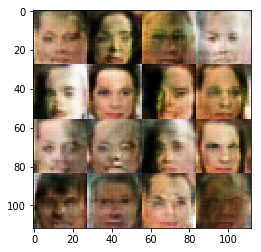

Epoch 1/1... Discriminator Loss: 2.4884... Generator Loss: 0.1430
Epoch 1/1... Discriminator Loss: 2.7178... Generator Loss: 0.1591
Epoch 1/1... Discriminator Loss: 2.6955... Generator Loss: 0.1211
Epoch 1/1... Discriminator Loss: 2.6468... Generator Loss: 0.1067
Epoch 1/1... Discriminator Loss: 2.4962... Generator Loss: 0.1647
Epoch 1/1... Discriminator Loss: 2.8811... Generator Loss: 0.1359
Epoch 1/1... Discriminator Loss: 2.4747... Generator Loss: 0.1133
Epoch 1/1... Discriminator Loss: 2.4668... Generator Loss: 0.1079
Epoch 1/1... Discriminator Loss: 2.6194... Generator Loss: 0.0877
Epoch 1/1... Discriminator Loss: 2.6358... Generator Loss: 0.0898


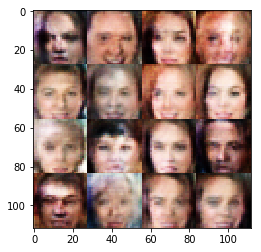

Epoch 1/1... Discriminator Loss: 2.6922... Generator Loss: 0.1030
Epoch 1/1... Discriminator Loss: 2.5423... Generator Loss: 0.1177
Epoch 1/1... Discriminator Loss: 2.7852... Generator Loss: 0.0843
Epoch 1/1... Discriminator Loss: 2.4224... Generator Loss: 0.1226
Epoch 1/1... Discriminator Loss: 2.4895... Generator Loss: 0.1533
Epoch 1/1... Discriminator Loss: 2.4535... Generator Loss: 0.1377
Epoch 1/1... Discriminator Loss: 2.3635... Generator Loss: 0.1576
Epoch 1/1... Discriminator Loss: 2.4644... Generator Loss: 0.1099
Epoch 1/1... Discriminator Loss: 2.4051... Generator Loss: 0.1747
Epoch 1/1... Discriminator Loss: 2.4054... Generator Loss: 0.1304


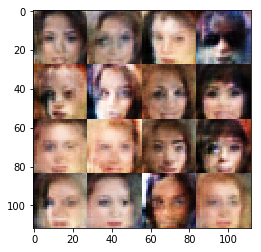

Epoch 1/1... Discriminator Loss: 2.6224... Generator Loss: 0.0852
Epoch 1/1... Discriminator Loss: 2.4510... Generator Loss: 0.1368
Epoch 1/1... Discriminator Loss: 2.6012... Generator Loss: 0.1303
Epoch 1/1... Discriminator Loss: 2.7824... Generator Loss: 0.0767
Epoch 1/1... Discriminator Loss: 2.7990... Generator Loss: 0.0740
Epoch 1/1... Discriminator Loss: 3.0518... Generator Loss: 0.0543
Epoch 1/1... Discriminator Loss: 2.7001... Generator Loss: 0.0961
Epoch 1/1... Discriminator Loss: 2.5294... Generator Loss: 0.2079
Epoch 1/1... Discriminator Loss: 2.3948... Generator Loss: 0.1746
Epoch 1/1... Discriminator Loss: 2.3273... Generator Loss: 0.1466


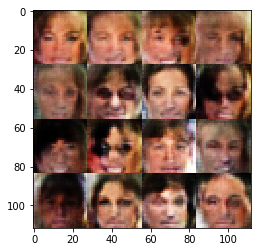

Epoch 1/1... Discriminator Loss: 2.6704... Generator Loss: 0.1181
Epoch 1/1... Discriminator Loss: 2.8192... Generator Loss: 0.1408
Epoch 1/1... Discriminator Loss: 2.3626... Generator Loss: 0.1361
Epoch 1/1... Discriminator Loss: 2.8833... Generator Loss: 0.0804
Epoch 1/1... Discriminator Loss: 2.7519... Generator Loss: 0.1195
Epoch 1/1... Discriminator Loss: 2.6145... Generator Loss: 0.0981
Epoch 1/1... Discriminator Loss: 2.3889... Generator Loss: 0.2599
Epoch 1/1... Discriminator Loss: 2.6287... Generator Loss: 0.1304
Epoch 1/1... Discriminator Loss: 2.4853... Generator Loss: 0.2216
Epoch 1/1... Discriminator Loss: 2.7564... Generator Loss: 0.0981


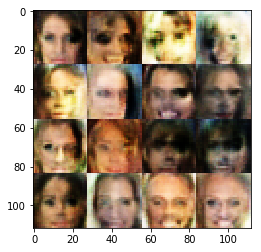

Epoch 1/1... Discriminator Loss: 2.3019... Generator Loss: 0.1413
Epoch 1/1... Discriminator Loss: 2.4369... Generator Loss: 0.1133
Epoch 1/1... Discriminator Loss: 2.7479... Generator Loss: 0.1493
Epoch 1/1... Discriminator Loss: 2.3301... Generator Loss: 0.1320
Epoch 1/1... Discriminator Loss: 2.4302... Generator Loss: 0.1346
Epoch 1/1... Discriminator Loss: 2.3293... Generator Loss: 0.1701
Epoch 1/1... Discriminator Loss: 2.8379... Generator Loss: 0.0812
Epoch 1/1... Discriminator Loss: 2.7590... Generator Loss: 0.1094
Epoch 1/1... Discriminator Loss: 2.2316... Generator Loss: 0.1630
Epoch 1/1... Discriminator Loss: 2.7250... Generator Loss: 0.0940


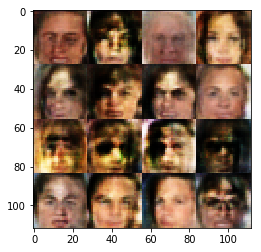

Epoch 1/1... Discriminator Loss: 2.2408... Generator Loss: 0.1702
Epoch 1/1... Discriminator Loss: 2.4750... Generator Loss: 0.1205
Epoch 1/1... Discriminator Loss: 2.7295... Generator Loss: 0.0841
Epoch 1/1... Discriminator Loss: 2.4211... Generator Loss: 0.1176
Epoch 1/1... Discriminator Loss: 2.1671... Generator Loss: 0.2062
Epoch 1/1... Discriminator Loss: 2.3633... Generator Loss: 0.1773
Epoch 1/1... Discriminator Loss: 2.4341... Generator Loss: 0.1285
Epoch 1/1... Discriminator Loss: 2.7194... Generator Loss: 0.0977
Epoch 1/1... Discriminator Loss: 2.3478... Generator Loss: 0.1156
Epoch 1/1... Discriminator Loss: 2.6256... Generator Loss: 0.0958


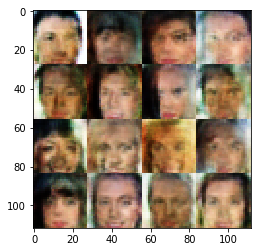

Epoch 1/1... Discriminator Loss: 2.4217... Generator Loss: 0.1240
Epoch 1/1... Discriminator Loss: 2.4745... Generator Loss: 0.1733
Epoch 1/1... Discriminator Loss: 2.3102... Generator Loss: 0.1755
Epoch 1/1... Discriminator Loss: 2.8749... Generator Loss: 0.0917
Epoch 1/1... Discriminator Loss: 2.9288... Generator Loss: 0.1524
Epoch 1/1... Discriminator Loss: 2.4410... Generator Loss: 0.1123
Epoch 1/1... Discriminator Loss: 2.5748... Generator Loss: 0.1218
Epoch 1/1... Discriminator Loss: 2.6078... Generator Loss: 0.1253
Epoch 1/1... Discriminator Loss: 2.2092... Generator Loss: 0.1501
Epoch 1/1... Discriminator Loss: 3.0898... Generator Loss: 0.0885


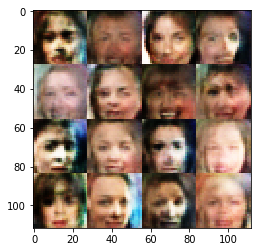

Epoch 1/1... Discriminator Loss: 2.9098... Generator Loss: 0.0882
Epoch 1/1... Discriminator Loss: 2.4512... Generator Loss: 0.1668
Epoch 1/1... Discriminator Loss: 2.3595... Generator Loss: 0.1524
Epoch 1/1... Discriminator Loss: 2.5159... Generator Loss: 0.1213
Epoch 1/1... Discriminator Loss: 2.8077... Generator Loss: 0.1182
Epoch 1/1... Discriminator Loss: 2.4400... Generator Loss: 0.1310
Epoch 1/1... Discriminator Loss: 2.5627... Generator Loss: 0.0964
Epoch 1/1... Discriminator Loss: 2.8727... Generator Loss: 0.0794
Epoch 1/1... Discriminator Loss: 2.7035... Generator Loss: 0.1271
Epoch 1/1... Discriminator Loss: 2.3643... Generator Loss: 0.1772


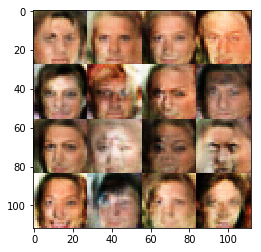

Epoch 1/1... Discriminator Loss: 2.5665... Generator Loss: 0.1255
Epoch 1/1... Discriminator Loss: 2.5647... Generator Loss: 0.1118
Epoch 1/1... Discriminator Loss: 2.3783... Generator Loss: 0.1518
Epoch 1/1... Discriminator Loss: 2.7337... Generator Loss: 0.1062
Epoch 1/1... Discriminator Loss: 2.7092... Generator Loss: 0.1409
Epoch 1/1... Discriminator Loss: 2.5525... Generator Loss: 0.1509
Epoch 1/1... Discriminator Loss: 2.8237... Generator Loss: 0.1041
Epoch 1/1... Discriminator Loss: 2.3055... Generator Loss: 0.1352
Epoch 1/1... Discriminator Loss: 2.6640... Generator Loss: 0.0884
Epoch 1/1... Discriminator Loss: 2.5021... Generator Loss: 0.1157


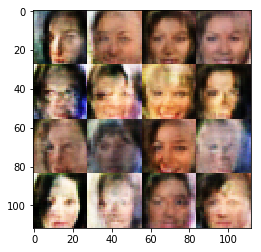

Epoch 1/1... Discriminator Loss: 2.3658... Generator Loss: 0.2839
Epoch 1/1... Discriminator Loss: 3.2036... Generator Loss: 0.0612
Epoch 1/1... Discriminator Loss: 2.4049... Generator Loss: 0.1280
Epoch 1/1... Discriminator Loss: 2.3875... Generator Loss: 0.2427
Epoch 1/1... Discriminator Loss: 2.5835... Generator Loss: 0.1179
Epoch 1/1... Discriminator Loss: 2.3000... Generator Loss: 0.1962
Epoch 1/1... Discriminator Loss: 2.3504... Generator Loss: 0.1525
Epoch 1/1... Discriminator Loss: 2.6061... Generator Loss: 0.1000
Epoch 1/1... Discriminator Loss: 2.2136... Generator Loss: 0.1573
Epoch 1/1... Discriminator Loss: 2.5686... Generator Loss: 0.1979


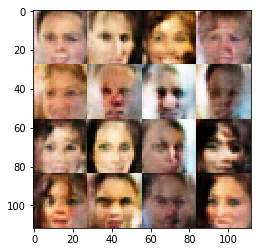

Epoch 1/1... Discriminator Loss: 2.5295... Generator Loss: 0.1109
Epoch 1/1... Discriminator Loss: 2.6377... Generator Loss: 0.1003
Epoch 1/1... Discriminator Loss: 2.4943... Generator Loss: 0.1021
Epoch 1/1... Discriminator Loss: 2.5786... Generator Loss: 0.1066
Epoch 1/1... Discriminator Loss: 2.9354... Generator Loss: 0.0981
Epoch 1/1... Discriminator Loss: 2.7669... Generator Loss: 0.1245
Epoch 1/1... Discriminator Loss: 2.3832... Generator Loss: 0.1285
Epoch 1/1... Discriminator Loss: 2.9074... Generator Loss: 0.1381
Epoch 1/1... Discriminator Loss: 2.4462... Generator Loss: 0.1054
Epoch 1/1... Discriminator Loss: 2.3526... Generator Loss: 0.1162


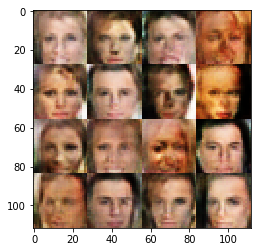

Epoch 1/1... Discriminator Loss: 2.4633... Generator Loss: 0.1201
Epoch 1/1... Discriminator Loss: 2.5084... Generator Loss: 0.1326
Epoch 1/1... Discriminator Loss: 2.6040... Generator Loss: 0.1005
Epoch 1/1... Discriminator Loss: 2.9024... Generator Loss: 0.1563
Epoch 1/1... Discriminator Loss: 2.6261... Generator Loss: 0.1103
Epoch 1/1... Discriminator Loss: 2.3696... Generator Loss: 0.1239
Epoch 1/1... Discriminator Loss: 2.6701... Generator Loss: 0.1069
Epoch 1/1... Discriminator Loss: 2.5872... Generator Loss: 0.1019
Epoch 1/1... Discriminator Loss: 3.0083... Generator Loss: 0.1242
Epoch 1/1... Discriminator Loss: 2.0267... Generator Loss: 0.2868


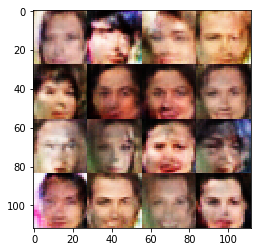

Epoch 1/1... Discriminator Loss: 2.6830... Generator Loss: 0.1103
Epoch 1/1... Discriminator Loss: 2.5944... Generator Loss: 0.1063
Epoch 1/1... Discriminator Loss: 2.6295... Generator Loss: 0.1006
Epoch 1/1... Discriminator Loss: 2.6850... Generator Loss: 0.1129
Epoch 1/1... Discriminator Loss: 2.7507... Generator Loss: 0.0988
Epoch 1/1... Discriminator Loss: 2.4283... Generator Loss: 0.1261
Epoch 1/1... Discriminator Loss: 2.5034... Generator Loss: 0.1554
Epoch 1/1... Discriminator Loss: 2.7356... Generator Loss: 0.1538
Epoch 1/1... Discriminator Loss: 2.4780... Generator Loss: 0.1115
Epoch 1/1... Discriminator Loss: 2.4118... Generator Loss: 0.1528


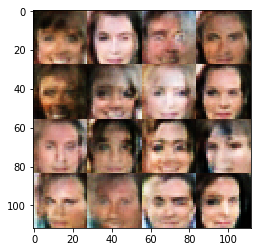

Epoch 1/1... Discriminator Loss: 2.3476... Generator Loss: 0.1249
Epoch 1/1... Discriminator Loss: 2.6188... Generator Loss: 0.1354
Epoch 1/1... Discriminator Loss: 2.6645... Generator Loss: 0.1162
Epoch 1/1... Discriminator Loss: 2.4378... Generator Loss: 0.1224
Epoch 1/1... Discriminator Loss: 2.6138... Generator Loss: 0.0935
Epoch 1/1... Discriminator Loss: 2.5090... Generator Loss: 0.1227
Epoch 1/1... Discriminator Loss: 2.4276... Generator Loss: 0.1223
Epoch 1/1... Discriminator Loss: 2.5145... Generator Loss: 0.1608
Epoch 1/1... Discriminator Loss: 2.3293... Generator Loss: 0.1237
Epoch 1/1... Discriminator Loss: 2.4001... Generator Loss: 0.1877


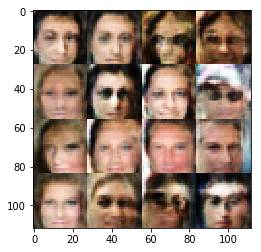

Epoch 1/1... Discriminator Loss: 2.4169... Generator Loss: 0.1344
Epoch 1/1... Discriminator Loss: 2.7723... Generator Loss: 0.0948
Epoch 1/1... Discriminator Loss: 2.5060... Generator Loss: 0.1863
Epoch 1/1... Discriminator Loss: 2.4445... Generator Loss: 0.1367
Epoch 1/1... Discriminator Loss: 2.4523... Generator Loss: 0.1142
Epoch 1/1... Discriminator Loss: 2.6342... Generator Loss: 0.0944
Epoch 1/1... Discriminator Loss: 2.8848... Generator Loss: 0.1047
Epoch 1/1... Discriminator Loss: 2.6977... Generator Loss: 0.1159
Epoch 1/1... Discriminator Loss: 2.8520... Generator Loss: 0.1754
Epoch 1/1... Discriminator Loss: 2.6183... Generator Loss: 0.1078


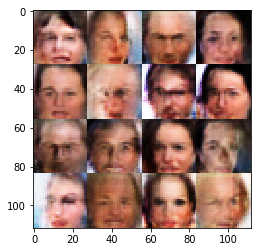

Epoch 1/1... Discriminator Loss: 2.4239... Generator Loss: 0.1446
Epoch 1/1... Discriminator Loss: 2.4794... Generator Loss: 0.1023
Epoch 1/1... Discriminator Loss: 2.4455... Generator Loss: 0.1069
Epoch 1/1... Discriminator Loss: 2.2373... Generator Loss: 0.1450
Epoch 1/1... Discriminator Loss: 2.7847... Generator Loss: 0.0754
Epoch 1/1... Discriminator Loss: 2.7517... Generator Loss: 0.1468
Epoch 1/1... Discriminator Loss: 2.4896... Generator Loss: 0.1031
Epoch 1/1... Discriminator Loss: 2.5556... Generator Loss: 0.1317
Epoch 1/1... Discriminator Loss: 2.5542... Generator Loss: 0.1069
Epoch 1/1... Discriminator Loss: 2.4554... Generator Loss: 0.1271


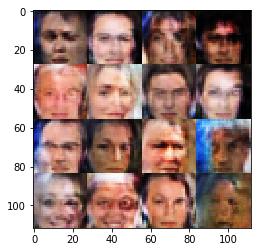

Epoch 1/1... Discriminator Loss: 2.9153... Generator Loss: 0.0650
Epoch 1/1... Discriminator Loss: 2.6613... Generator Loss: 0.1102
Epoch 1/1... Discriminator Loss: 3.6097... Generator Loss: 0.0382
Epoch 1/1... Discriminator Loss: 2.6448... Generator Loss: 0.0981
Epoch 1/1... Discriminator Loss: 2.4188... Generator Loss: 0.1101
Epoch 1/1... Discriminator Loss: 2.9593... Generator Loss: 0.0694
Epoch 1/1... Discriminator Loss: 2.7073... Generator Loss: 0.0832
Epoch 1/1... Discriminator Loss: 2.4391... Generator Loss: 0.1322
Epoch 1/1... Discriminator Loss: 2.6005... Generator Loss: 0.0983
Epoch 1/1... Discriminator Loss: 2.3938... Generator Loss: 0.2498


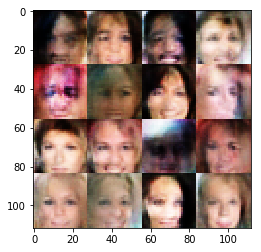

Epoch 1/1... Discriminator Loss: 2.9732... Generator Loss: 0.0762
Epoch 1/1... Discriminator Loss: 2.7249... Generator Loss: 0.0951
Epoch 1/1... Discriminator Loss: 2.4074... Generator Loss: 0.1328
Epoch 1/1... Discriminator Loss: 2.2651... Generator Loss: 0.1622
Epoch 1/1... Discriminator Loss: 2.7417... Generator Loss: 0.0953
Epoch 1/1... Discriminator Loss: 2.5472... Generator Loss: 0.1023
Epoch 1/1... Discriminator Loss: 2.2593... Generator Loss: 0.2250
Epoch 1/1... Discriminator Loss: 2.4468... Generator Loss: 0.1076
Epoch 1/1... Discriminator Loss: 2.2854... Generator Loss: 0.1755
Epoch 1/1... Discriminator Loss: 2.4381... Generator Loss: 0.1215


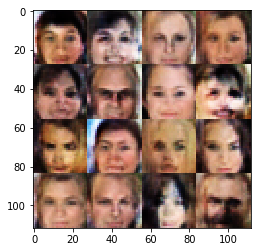

Epoch 1/1... Discriminator Loss: 2.7029... Generator Loss: 0.0795
Epoch 1/1... Discriminator Loss: 2.8383... Generator Loss: 0.0752
Epoch 1/1... Discriminator Loss: 2.6382... Generator Loss: 0.1580
Epoch 1/1... Discriminator Loss: 2.7458... Generator Loss: 0.1508
Epoch 1/1... Discriminator Loss: 2.7258... Generator Loss: 0.0830
Epoch 1/1... Discriminator Loss: 2.5032... Generator Loss: 0.1024
Epoch 1/1... Discriminator Loss: 2.7520... Generator Loss: 0.0878
Epoch 1/1... Discriminator Loss: 2.8830... Generator Loss: 0.0730
Epoch 1/1... Discriminator Loss: 2.3107... Generator Loss: 0.2239
Epoch 1/1... Discriminator Loss: 2.5607... Generator Loss: 0.0951


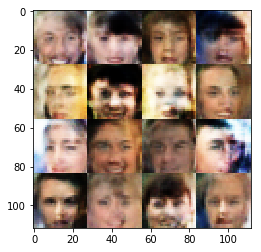

Epoch 1/1... Discriminator Loss: 2.3308... Generator Loss: 0.1301
Epoch 1/1... Discriminator Loss: 2.4371... Generator Loss: 0.1489
Epoch 1/1... Discriminator Loss: 2.2359... Generator Loss: 0.2825
Epoch 1/1... Discriminator Loss: 3.1128... Generator Loss: 0.0894
Epoch 1/1... Discriminator Loss: 2.5815... Generator Loss: 0.1950
Epoch 1/1... Discriminator Loss: 2.5186... Generator Loss: 0.1005
Epoch 1/1... Discriminator Loss: 2.5561... Generator Loss: 0.1015
Epoch 1/1... Discriminator Loss: 2.2663... Generator Loss: 0.1430
Epoch 1/1... Discriminator Loss: 2.6472... Generator Loss: 0.0967
Epoch 1/1... Discriminator Loss: 2.5380... Generator Loss: 0.1338


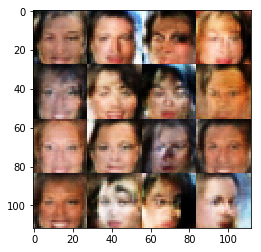

Epoch 1/1... Discriminator Loss: 2.7970... Generator Loss: 0.0749
Epoch 1/1... Discriminator Loss: 2.6720... Generator Loss: 0.1246
Epoch 1/1... Discriminator Loss: 2.8050... Generator Loss: 0.0833
Epoch 1/1... Discriminator Loss: 2.6460... Generator Loss: 0.1181
Epoch 1/1... Discriminator Loss: 2.4022... Generator Loss: 0.1264
Epoch 1/1... Discriminator Loss: 2.6173... Generator Loss: 0.1016
Epoch 1/1... Discriminator Loss: 2.4153... Generator Loss: 0.1215
Epoch 1/1... Discriminator Loss: 2.6514... Generator Loss: 0.0793
Epoch 1/1... Discriminator Loss: 2.5417... Generator Loss: 0.1145
Epoch 1/1... Discriminator Loss: 2.4298... Generator Loss: 0.1056


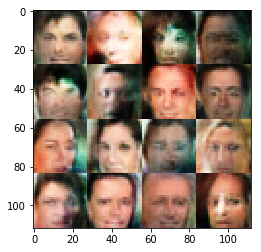

Epoch 1/1... Discriminator Loss: 3.1922... Generator Loss: 0.0722
Epoch 1/1... Discriminator Loss: 2.5650... Generator Loss: 0.1058
Epoch 1/1... Discriminator Loss: 2.6769... Generator Loss: 0.1483
Epoch 1/1... Discriminator Loss: 2.8572... Generator Loss: 0.0683
Epoch 1/1... Discriminator Loss: 2.5917... Generator Loss: 0.1159
Epoch 1/1... Discriminator Loss: 2.6308... Generator Loss: 0.0823
Epoch 1/1... Discriminator Loss: 2.7926... Generator Loss: 0.0702
Epoch 1/1... Discriminator Loss: 3.1835... Generator Loss: 0.0655
Epoch 1/1... Discriminator Loss: 2.7413... Generator Loss: 0.1530
Epoch 1/1... Discriminator Loss: 2.3177... Generator Loss: 0.2392


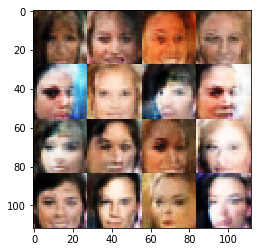

Epoch 1/1... Discriminator Loss: 2.1165... Generator Loss: 0.1922
Epoch 1/1... Discriminator Loss: 2.6528... Generator Loss: 0.0892
Epoch 1/1... Discriminator Loss: 2.6315... Generator Loss: 0.1426
Epoch 1/1... Discriminator Loss: 2.6961... Generator Loss: 0.1084
Epoch 1/1... Discriminator Loss: 2.2622... Generator Loss: 0.1974
Epoch 1/1... Discriminator Loss: 2.4300... Generator Loss: 0.1528
Epoch 1/1... Discriminator Loss: 2.3825... Generator Loss: 0.1173
Epoch 1/1... Discriminator Loss: 2.4112... Generator Loss: 0.1565
Epoch 1/1... Discriminator Loss: 2.5214... Generator Loss: 0.0990
Epoch 1/1... Discriminator Loss: 2.2181... Generator Loss: 0.1627


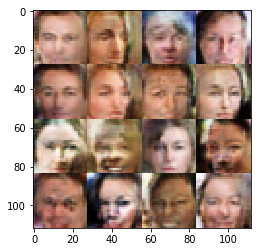

Epoch 1/1... Discriminator Loss: 2.7971... Generator Loss: 0.0820
Epoch 1/1... Discriminator Loss: 2.9050... Generator Loss: 0.0880
Epoch 1/1... Discriminator Loss: 2.6477... Generator Loss: 0.1419
Epoch 1/1... Discriminator Loss: 2.6134... Generator Loss: 0.1548
Epoch 1/1... Discriminator Loss: 2.5248... Generator Loss: 0.1019
Epoch 1/1... Discriminator Loss: 2.3889... Generator Loss: 0.1090
Epoch 1/1... Discriminator Loss: 2.8382... Generator Loss: 0.0873
Epoch 1/1... Discriminator Loss: 2.5405... Generator Loss: 0.0957
Epoch 1/1... Discriminator Loss: 2.5635... Generator Loss: 0.1917
Epoch 1/1... Discriminator Loss: 2.8363... Generator Loss: 0.1501


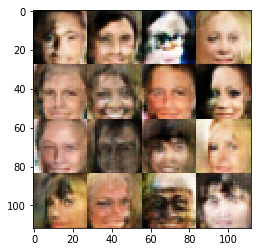

Epoch 1/1... Discriminator Loss: 2.7074... Generator Loss: 0.0918
Epoch 1/1... Discriminator Loss: 2.6545... Generator Loss: 0.1018
Epoch 1/1... Discriminator Loss: 2.5865... Generator Loss: 0.1342
Epoch 1/1... Discriminator Loss: 2.2466... Generator Loss: 0.2067
Epoch 1/1... Discriminator Loss: 2.3506... Generator Loss: 0.1531
Epoch 1/1... Discriminator Loss: 2.4131... Generator Loss: 0.1395
Epoch 1/1... Discriminator Loss: 2.4367... Generator Loss: 0.1162
Epoch 1/1... Discriminator Loss: 3.1220... Generator Loss: 0.0749
Epoch 1/1... Discriminator Loss: 2.6015... Generator Loss: 0.1228
Epoch 1/1... Discriminator Loss: 2.6064... Generator Loss: 0.1599


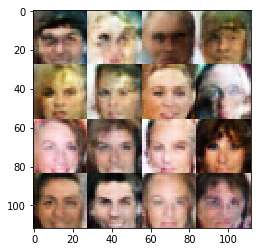

Epoch 1/1... Discriminator Loss: 2.2561... Generator Loss: 0.1542
Epoch 1/1... Discriminator Loss: 2.6589... Generator Loss: 0.0907
Epoch 1/1... Discriminator Loss: 2.9199... Generator Loss: 0.1898
Epoch 1/1... Discriminator Loss: 2.5356... Generator Loss: 0.1194
Epoch 1/1... Discriminator Loss: 2.1092... Generator Loss: 0.2058
Epoch 1/1... Discriminator Loss: 2.8551... Generator Loss: 0.1141
Epoch 1/1... Discriminator Loss: 2.3921... Generator Loss: 0.1234
Epoch 1/1... Discriminator Loss: 2.6469... Generator Loss: 0.1390
Epoch 1/1... Discriminator Loss: 2.7461... Generator Loss: 0.0739
Epoch 1/1... Discriminator Loss: 2.8089... Generator Loss: 0.1024


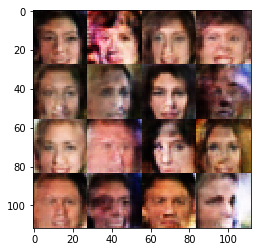

Epoch 1/1... Discriminator Loss: 2.4502... Generator Loss: 0.1048
Epoch 1/1... Discriminator Loss: 2.5069... Generator Loss: 0.1090
Epoch 1/1... Discriminator Loss: 2.3937... Generator Loss: 0.2042
Epoch 1/1... Discriminator Loss: 2.2868... Generator Loss: 0.1435
Epoch 1/1... Discriminator Loss: 2.4332... Generator Loss: 0.1675
Epoch 1/1... Discriminator Loss: 2.6478... Generator Loss: 0.0971
Epoch 1/1... Discriminator Loss: 2.3103... Generator Loss: 0.1842
Epoch 1/1... Discriminator Loss: 2.6166... Generator Loss: 0.1297
Epoch 1/1... Discriminator Loss: 2.6411... Generator Loss: 0.1109
Epoch 1/1... Discriminator Loss: 2.3183... Generator Loss: 0.2268


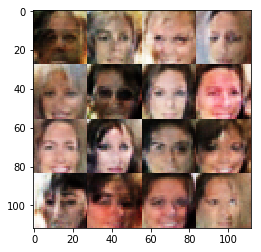

Epoch 1/1... Discriminator Loss: 2.3168... Generator Loss: 0.2008
Epoch 1/1... Discriminator Loss: 2.5182... Generator Loss: 0.0954
Epoch 1/1... Discriminator Loss: 2.6462... Generator Loss: 0.1055
Epoch 1/1... Discriminator Loss: 2.6609... Generator Loss: 0.0867
Epoch 1/1... Discriminator Loss: 2.5162... Generator Loss: 0.1194
Epoch 1/1... Discriminator Loss: 2.8890... Generator Loss: 0.1111
Epoch 1/1... Discriminator Loss: 2.5402... Generator Loss: 0.1206
Epoch 1/1... Discriminator Loss: 2.7005... Generator Loss: 0.1026
Epoch 1/1... Discriminator Loss: 2.5869... Generator Loss: 0.1086
Epoch 1/1... Discriminator Loss: 2.3860... Generator Loss: 0.1430


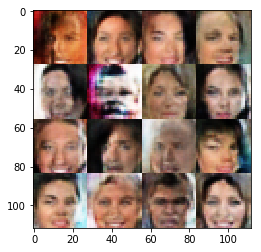

Epoch 1/1... Discriminator Loss: 2.6549... Generator Loss: 0.1075
Epoch 1/1... Discriminator Loss: 2.3499... Generator Loss: 0.1303
Epoch 1/1... Discriminator Loss: 2.7653... Generator Loss: 0.1012
Epoch 1/1... Discriminator Loss: 2.3609... Generator Loss: 0.1198
Epoch 1/1... Discriminator Loss: 2.6261... Generator Loss: 0.1534
Epoch 1/1... Discriminator Loss: 2.8152... Generator Loss: 0.1086
Epoch 1/1... Discriminator Loss: 2.4426... Generator Loss: 0.1674
Epoch 1/1... Discriminator Loss: 1.7940... Generator Loss: 0.2032
Epoch 1/1... Discriminator Loss: 2.6854... Generator Loss: 0.1470
Epoch 1/1... Discriminator Loss: 2.5766... Generator Loss: 0.0969


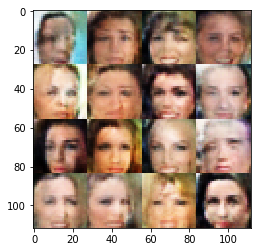

Epoch 1/1... Discriminator Loss: 2.4301... Generator Loss: 0.2247
Epoch 1/1... Discriminator Loss: 2.4774... Generator Loss: 0.1479
Epoch 1/1... Discriminator Loss: 2.7422... Generator Loss: 0.1267
Epoch 1/1... Discriminator Loss: 2.4769... Generator Loss: 0.1074
Epoch 1/1... Discriminator Loss: 2.5168... Generator Loss: 0.1729
Epoch 1/1... Discriminator Loss: 2.7549... Generator Loss: 0.0732
Epoch 1/1... Discriminator Loss: 2.3442... Generator Loss: 0.1370
Epoch 1/1... Discriminator Loss: 2.6180... Generator Loss: 0.1040
Epoch 1/1... Discriminator Loss: 2.8244... Generator Loss: 0.0805
Epoch 1/1... Discriminator Loss: 2.5961... Generator Loss: 0.1307


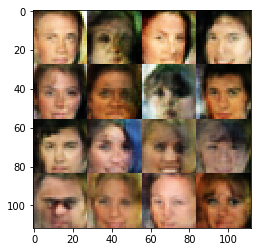

Epoch 1/1... Discriminator Loss: 2.7318... Generator Loss: 0.0770
Epoch 1/1... Discriminator Loss: 2.5604... Generator Loss: 0.1080
Epoch 1/1... Discriminator Loss: 2.5955... Generator Loss: 0.1370
Epoch 1/1... Discriminator Loss: 2.4597... Generator Loss: 0.1252
Epoch 1/1... Discriminator Loss: 2.4321... Generator Loss: 0.1625
Epoch 1/1... Discriminator Loss: 2.7651... Generator Loss: 0.0766
Epoch 1/1... Discriminator Loss: 2.9830... Generator Loss: 0.0584
Epoch 1/1... Discriminator Loss: 2.9858... Generator Loss: 0.1110
Epoch 1/1... Discriminator Loss: 2.6185... Generator Loss: 0.1106
Epoch 1/1... Discriminator Loss: 2.2357... Generator Loss: 0.2742


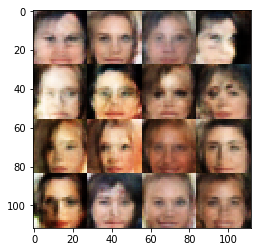

Epoch 1/1... Discriminator Loss: 2.6192... Generator Loss: 0.1316
Epoch 1/1... Discriminator Loss: 2.7991... Generator Loss: 0.0927
Epoch 1/1... Discriminator Loss: 2.3139... Generator Loss: 0.1367
Epoch 1/1... Discriminator Loss: 2.6945... Generator Loss: 0.0881
Epoch 1/1... Discriminator Loss: 2.6562... Generator Loss: 0.1844
Epoch 1/1... Discriminator Loss: 2.3127... Generator Loss: 0.1256
Epoch 1/1... Discriminator Loss: 2.6944... Generator Loss: 0.0829
Epoch 1/1... Discriminator Loss: 2.4293... Generator Loss: 0.1802
Epoch 1/1... Discriminator Loss: 2.4470... Generator Loss: 0.1045
Epoch 1/1... Discriminator Loss: 2.8470... Generator Loss: 0.0995


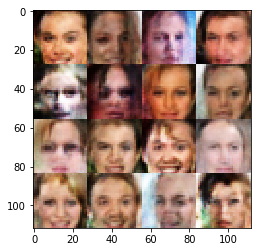

Epoch 1/1... Discriminator Loss: 2.4245... Generator Loss: 0.1174
Epoch 1/1... Discriminator Loss: 2.2504... Generator Loss: 0.1745
Epoch 1/1... Discriminator Loss: 2.7041... Generator Loss: 0.1428
Epoch 1/1... Discriminator Loss: 2.3089... Generator Loss: 0.1800
Epoch 1/1... Discriminator Loss: 2.5966... Generator Loss: 0.1782
Epoch 1/1... Discriminator Loss: 2.5861... Generator Loss: 0.2061
Epoch 1/1... Discriminator Loss: 2.1761... Generator Loss: 0.2046
Epoch 1/1... Discriminator Loss: 2.7553... Generator Loss: 0.0758
Epoch 1/1... Discriminator Loss: 2.2765... Generator Loss: 0.1902
Epoch 1/1... Discriminator Loss: 2.1730... Generator Loss: 0.1925


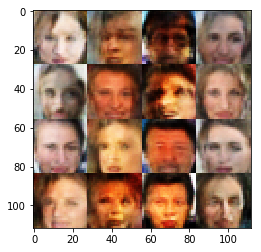

Epoch 1/1... Discriminator Loss: 2.1253... Generator Loss: 0.1665
Epoch 1/1... Discriminator Loss: 2.5067... Generator Loss: 0.1031
Epoch 1/1... Discriminator Loss: 2.4195... Generator Loss: 0.1050
Epoch 1/1... Discriminator Loss: 2.4285... Generator Loss: 0.1354
Epoch 1/1... Discriminator Loss: 2.7969... Generator Loss: 0.0777
Epoch 1/1... Discriminator Loss: 2.4960... Generator Loss: 0.1651
Epoch 1/1... Discriminator Loss: 2.7613... Generator Loss: 0.0830
Epoch 1/1... Discriminator Loss: 2.4436... Generator Loss: 0.2218
Epoch 1/1... Discriminator Loss: 2.6160... Generator Loss: 0.1032
Epoch 1/1... Discriminator Loss: 2.4893... Generator Loss: 0.1291


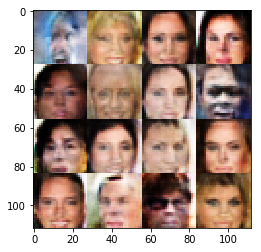

Epoch 1/1... Discriminator Loss: 2.6663... Generator Loss: 0.1740
Epoch 1/1... Discriminator Loss: 2.9407... Generator Loss: 0.0790
Epoch 1/1... Discriminator Loss: 2.8229... Generator Loss: 0.1013
Epoch 1/1... Discriminator Loss: 2.4233... Generator Loss: 0.1649
Epoch 1/1... Discriminator Loss: 2.4682... Generator Loss: 0.1123
Epoch 1/1... Discriminator Loss: 2.6396... Generator Loss: 0.0928
Epoch 1/1... Discriminator Loss: 2.7387... Generator Loss: 0.0923
Epoch 1/1... Discriminator Loss: 2.4922... Generator Loss: 0.0964
Epoch 1/1... Discriminator Loss: 3.0059... Generator Loss: 0.0635
Epoch 1/1... Discriminator Loss: 2.8349... Generator Loss: 0.0697


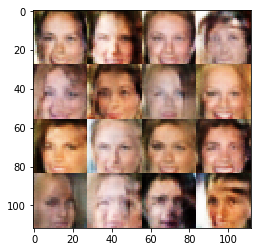

Epoch 1/1... Discriminator Loss: 1.9301... Generator Loss: 0.2845
Epoch 1/1... Discriminator Loss: 3.1806... Generator Loss: 0.0518
Epoch 1/1... Discriminator Loss: 2.8354... Generator Loss: 0.0758
Epoch 1/1... Discriminator Loss: 2.6856... Generator Loss: 0.0880
Epoch 1/1... Discriminator Loss: 2.5774... Generator Loss: 0.1849
Epoch 1/1... Discriminator Loss: 2.5309... Generator Loss: 0.1293
Epoch 1/1... Discriminator Loss: 2.3965... Generator Loss: 0.1319
Epoch 1/1... Discriminator Loss: 2.6558... Generator Loss: 0.0974
Epoch 1/1... Discriminator Loss: 2.7098... Generator Loss: 0.0933
Epoch 1/1... Discriminator Loss: 3.0461... Generator Loss: 0.0579


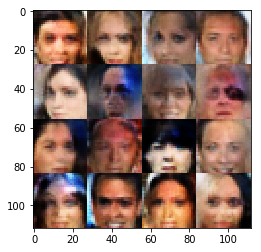

Epoch 1/1... Discriminator Loss: 2.4267... Generator Loss: 0.1594
Epoch 1/1... Discriminator Loss: 3.1620... Generator Loss: 0.0548
Epoch 1/1... Discriminator Loss: 2.5652... Generator Loss: 0.0975
Epoch 1/1... Discriminator Loss: 2.7237... Generator Loss: 0.1033
Epoch 1/1... Discriminator Loss: 2.6051... Generator Loss: 0.0960
Epoch 1/1... Discriminator Loss: 2.6327... Generator Loss: 0.1012
Epoch 1/1... Discriminator Loss: 3.2315... Generator Loss: 0.0422
Epoch 1/1... Discriminator Loss: 3.0289... Generator Loss: 0.0597
Epoch 1/1... Discriminator Loss: 2.6131... Generator Loss: 0.0923
Epoch 1/1... Discriminator Loss: 2.9293... Generator Loss: 0.0628


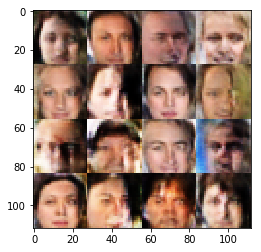

Epoch 1/1... Discriminator Loss: 2.6449... Generator Loss: 0.0858
Epoch 1/1... Discriminator Loss: 2.6155... Generator Loss: 0.1302
Epoch 1/1... Discriminator Loss: 2.6844... Generator Loss: 0.0801
Epoch 1/1... Discriminator Loss: 2.3657... Generator Loss: 0.1819
Epoch 1/1... Discriminator Loss: 2.6158... Generator Loss: 0.1681
Epoch 1/1... Discriminator Loss: 2.6497... Generator Loss: 0.0917
Epoch 1/1... Discriminator Loss: 2.5797... Generator Loss: 0.0954
Epoch 1/1... Discriminator Loss: 2.3608... Generator Loss: 0.1160
Epoch 1/1... Discriminator Loss: 2.5450... Generator Loss: 0.1332
Epoch 1/1... Discriminator Loss: 2.5611... Generator Loss: 0.0947


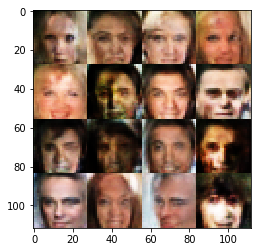

Epoch 1/1... Discriminator Loss: 2.8461... Generator Loss: 0.0932
Epoch 1/1... Discriminator Loss: 2.0919... Generator Loss: 0.4782
Epoch 1/1... Discriminator Loss: 2.1539... Generator Loss: 0.1707
Epoch 1/1... Discriminator Loss: 2.6848... Generator Loss: 0.1017
Epoch 1/1... Discriminator Loss: 2.5444... Generator Loss: 0.1001
Epoch 1/1... Discriminator Loss: 2.7148... Generator Loss: 0.1512
Epoch 1/1... Discriminator Loss: 2.3142... Generator Loss: 0.1842
Epoch 1/1... Discriminator Loss: 2.9762... Generator Loss: 0.0605
Epoch 1/1... Discriminator Loss: 2.3825... Generator Loss: 0.1161
Epoch 1/1... Discriminator Loss: 2.5183... Generator Loss: 0.1408


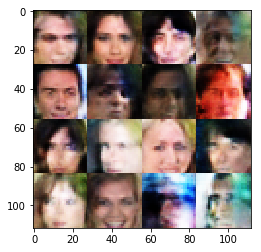

Epoch 1/1... Discriminator Loss: 2.4771... Generator Loss: 0.1058
Epoch 1/1... Discriminator Loss: 2.3558... Generator Loss: 0.1147
Epoch 1/1... Discriminator Loss: 2.8209... Generator Loss: 0.0727
Epoch 1/1... Discriminator Loss: 2.3972... Generator Loss: 0.2339
Epoch 1/1... Discriminator Loss: 2.6305... Generator Loss: 0.0909
Epoch 1/1... Discriminator Loss: 3.0598... Generator Loss: 0.1599
Epoch 1/1... Discriminator Loss: 2.0777... Generator Loss: 0.1670
Epoch 1/1... Discriminator Loss: 2.4989... Generator Loss: 0.0944
Epoch 1/1... Discriminator Loss: 3.1754... Generator Loss: 0.0594
Epoch 1/1... Discriminator Loss: 2.1706... Generator Loss: 0.2409


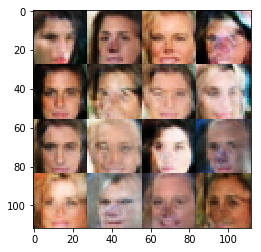

Epoch 1/1... Discriminator Loss: 2.7259... Generator Loss: 0.0773
Epoch 1/1... Discriminator Loss: 2.5380... Generator Loss: 0.1039
Epoch 1/1... Discriminator Loss: 2.9076... Generator Loss: 0.0663
Epoch 1/1... Discriminator Loss: 2.5036... Generator Loss: 0.1261
Epoch 1/1... Discriminator Loss: 2.6933... Generator Loss: 0.0869
Epoch 1/1... Discriminator Loss: 2.4154... Generator Loss: 0.1295
Epoch 1/1... Discriminator Loss: 2.3525... Generator Loss: 0.1409
Epoch 1/1... Discriminator Loss: 2.7925... Generator Loss: 0.0770
Epoch 1/1... Discriminator Loss: 2.6217... Generator Loss: 0.0995
Epoch 1/1... Discriminator Loss: 2.7238... Generator Loss: 0.0889


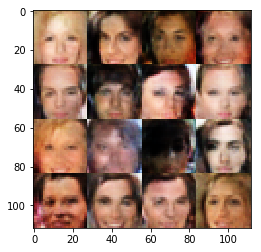

Epoch 1/1... Discriminator Loss: 2.6110... Generator Loss: 0.0903
Epoch 1/1... Discriminator Loss: 2.7378... Generator Loss: 0.1175
Epoch 1/1... Discriminator Loss: 2.1499... Generator Loss: 0.1931
Epoch 1/1... Discriminator Loss: 2.7375... Generator Loss: 0.1523
Epoch 1/1... Discriminator Loss: 2.2543... Generator Loss: 0.1857
Epoch 1/1... Discriminator Loss: 2.3544... Generator Loss: 0.2094
Epoch 1/1... Discriminator Loss: 2.4482... Generator Loss: 0.1167
Epoch 1/1... Discriminator Loss: 2.5726... Generator Loss: 0.1423
Epoch 1/1... Discriminator Loss: 2.8748... Generator Loss: 0.0716
Epoch 1/1... Discriminator Loss: 2.6920... Generator Loss: 0.0857


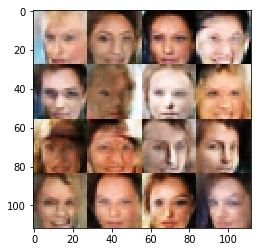

Epoch 1/1... Discriminator Loss: 2.7231... Generator Loss: 0.0780
Epoch 1/1... Discriminator Loss: 2.8730... Generator Loss: 0.0725
Epoch 1/1... Discriminator Loss: 2.5225... Generator Loss: 0.1707
Epoch 1/1... Discriminator Loss: 2.5425... Generator Loss: 0.0917
Epoch 1/1... Discriminator Loss: 2.6602... Generator Loss: 0.0881
Epoch 1/1... Discriminator Loss: 2.7559... Generator Loss: 0.1348
Epoch 1/1... Discriminator Loss: 2.5112... Generator Loss: 0.1807
Epoch 1/1... Discriminator Loss: 2.4279... Generator Loss: 0.1160
Epoch 1/1... Discriminator Loss: 2.2320... Generator Loss: 0.1341
Epoch 1/1... Discriminator Loss: 2.4128... Generator Loss: 0.2309


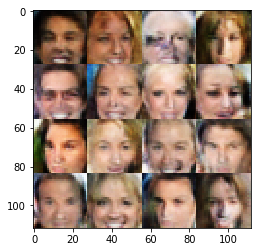

Epoch 1/1... Discriminator Loss: 2.8181... Generator Loss: 0.1405
Epoch 1/1... Discriminator Loss: 2.5731... Generator Loss: 0.1042
Epoch 1/1... Discriminator Loss: 2.4415... Generator Loss: 0.1224
Epoch 1/1... Discriminator Loss: 2.5469... Generator Loss: 0.1514
Epoch 1/1... Discriminator Loss: 3.0897... Generator Loss: 0.0663
Epoch 1/1... Discriminator Loss: 2.5306... Generator Loss: 0.0944
Epoch 1/1... Discriminator Loss: 2.7258... Generator Loss: 0.0824
Epoch 1/1... Discriminator Loss: 2.4557... Generator Loss: 0.1145
Epoch 1/1... Discriminator Loss: 2.3024... Generator Loss: 0.1969
Epoch 1/1... Discriminator Loss: 2.8149... Generator Loss: 0.1355


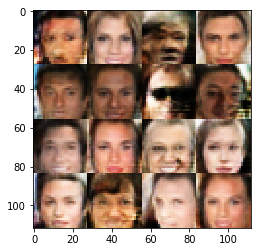

Epoch 1/1... Discriminator Loss: 1.9169... Generator Loss: 0.2480
Epoch 1/1... Discriminator Loss: 2.8961... Generator Loss: 0.1224
Epoch 1/1... Discriminator Loss: 2.4604... Generator Loss: 0.1468
Epoch 1/1... Discriminator Loss: 2.8598... Generator Loss: 0.1490
Epoch 1/1... Discriminator Loss: 2.6836... Generator Loss: 0.1339
Epoch 1/1... Discriminator Loss: 2.2823... Generator Loss: 0.1193
Epoch 1/1... Discriminator Loss: 2.4848... Generator Loss: 0.1062
Epoch 1/1... Discriminator Loss: 2.7543... Generator Loss: 0.0846
Epoch 1/1... Discriminator Loss: 2.6131... Generator Loss: 0.0940
Epoch 1/1... Discriminator Loss: 2.7329... Generator Loss: 0.0859


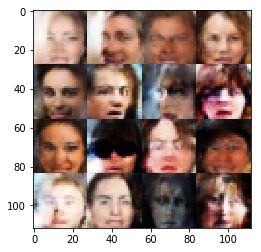

Epoch 1/1... Discriminator Loss: 2.8458... Generator Loss: 0.1215
Epoch 1/1... Discriminator Loss: 2.4804... Generator Loss: 0.1361
Epoch 1/1... Discriminator Loss: 2.9092... Generator Loss: 0.1842
Epoch 1/1... Discriminator Loss: 2.4072... Generator Loss: 0.1330
Epoch 1/1... Discriminator Loss: 2.4321... Generator Loss: 0.1258
Epoch 1/1... Discriminator Loss: 2.5664... Generator Loss: 0.1183
Epoch 1/1... Discriminator Loss: 2.5075... Generator Loss: 0.1124
Epoch 1/1... Discriminator Loss: 2.4879... Generator Loss: 0.1493
Epoch 1/1... Discriminator Loss: 2.6083... Generator Loss: 0.0945
Epoch 1/1... Discriminator Loss: 2.9163... Generator Loss: 0.0684


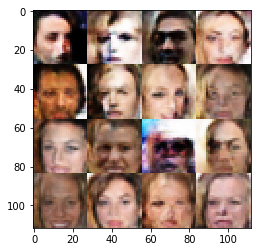

Epoch 1/1... Discriminator Loss: 2.5438... Generator Loss: 0.0924
Epoch 1/1... Discriminator Loss: 2.7328... Generator Loss: 0.0824
Epoch 1/1... Discriminator Loss: 2.7342... Generator Loss: 0.0778
Epoch 1/1... Discriminator Loss: 2.8536... Generator Loss: 0.2397
Epoch 1/1... Discriminator Loss: 2.5468... Generator Loss: 0.1263
Epoch 1/1... Discriminator Loss: 2.4255... Generator Loss: 0.1287
Epoch 1/1... Discriminator Loss: 2.8916... Generator Loss: 0.0892
Epoch 1/1... Discriminator Loss: 3.0299... Generator Loss: 0.0634
Epoch 1/1... Discriminator Loss: 2.5456... Generator Loss: 0.0905
Epoch 1/1... Discriminator Loss: 2.6695... Generator Loss: 0.0861


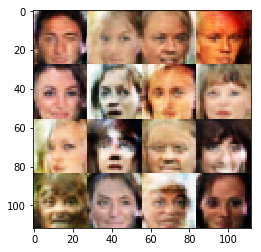

Epoch 1/1... Discriminator Loss: 2.6888... Generator Loss: 0.1142
Epoch 1/1... Discriminator Loss: 2.3428... Generator Loss: 0.1220
Epoch 1/1... Discriminator Loss: 2.2258... Generator Loss: 0.2026
Epoch 1/1... Discriminator Loss: 2.4478... Generator Loss: 0.1223
Epoch 1/1... Discriminator Loss: 3.1692... Generator Loss: 0.0554
Epoch 1/1... Discriminator Loss: 2.8496... Generator Loss: 0.0862
Epoch 1/1... Discriminator Loss: 2.5342... Generator Loss: 0.1275
Epoch 1/1... Discriminator Loss: 2.2995... Generator Loss: 0.2292
Epoch 1/1... Discriminator Loss: 2.0849... Generator Loss: 0.2175
Epoch 1/1... Discriminator Loss: 1.7342... Generator Loss: 0.2993


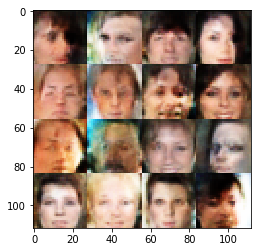

Epoch 1/1... Discriminator Loss: 2.3185... Generator Loss: 0.1451
Epoch 1/1... Discriminator Loss: 2.6239... Generator Loss: 0.1256
Epoch 1/1... Discriminator Loss: 2.5561... Generator Loss: 0.1068
Epoch 1/1... Discriminator Loss: 2.9006... Generator Loss: 0.0724
Epoch 1/1... Discriminator Loss: 2.6470... Generator Loss: 0.0966
Epoch 1/1... Discriminator Loss: 2.4492... Generator Loss: 0.1644
Epoch 1/1... Discriminator Loss: 3.0365... Generator Loss: 0.1153
Epoch 1/1... Discriminator Loss: 2.3586... Generator Loss: 0.1442
Epoch 1/1... Discriminator Loss: 3.0714... Generator Loss: 0.0619
Epoch 1/1... Discriminator Loss: 2.7958... Generator Loss: 0.1366


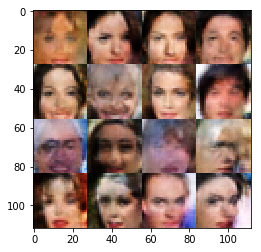

Epoch 1/1... Discriminator Loss: 2.5911... Generator Loss: 0.1050
Epoch 1/1... Discriminator Loss: 2.4364... Generator Loss: 0.1235
Epoch 1/1... Discriminator Loss: 1.7374... Generator Loss: 0.3301
Epoch 1/1... Discriminator Loss: 2.7151... Generator Loss: 0.0908
Epoch 1/1... Discriminator Loss: 2.6896... Generator Loss: 0.1258
Epoch 1/1... Discriminator Loss: 2.7983... Generator Loss: 0.1957
Epoch 1/1... Discriminator Loss: 2.1971... Generator Loss: 0.1814
Epoch 1/1... Discriminator Loss: 2.4160... Generator Loss: 0.1382
Epoch 1/1... Discriminator Loss: 2.7777... Generator Loss: 0.0817
Epoch 1/1... Discriminator Loss: 2.8294... Generator Loss: 0.1353


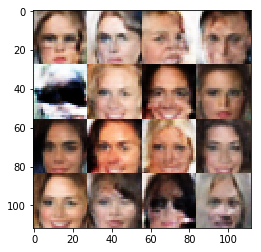

Epoch 1/1... Discriminator Loss: 2.6303... Generator Loss: 0.1384
Epoch 1/1... Discriminator Loss: 2.6721... Generator Loss: 0.1212
Epoch 1/1... Discriminator Loss: 2.4348... Generator Loss: 0.1118
Epoch 1/1... Discriminator Loss: 2.4585... Generator Loss: 0.1779
Epoch 1/1... Discriminator Loss: 2.5393... Generator Loss: 0.1132
Epoch 1/1... Discriminator Loss: 2.3058... Generator Loss: 0.1529
Epoch 1/1... Discriminator Loss: 2.2078... Generator Loss: 0.2096
Epoch 1/1... Discriminator Loss: 2.1918... Generator Loss: 0.1444
Epoch 1/1... Discriminator Loss: 3.1252... Generator Loss: 0.0529
Epoch 1/1... Discriminator Loss: 2.5536... Generator Loss: 0.1173


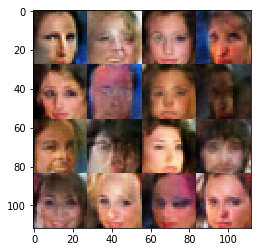

Epoch 1/1... Discriminator Loss: 2.8678... Generator Loss: 0.0842
Epoch 1/1... Discriminator Loss: 2.5615... Generator Loss: 0.0965
Epoch 1/1... Discriminator Loss: 3.1896... Generator Loss: 0.0507
Epoch 1/1... Discriminator Loss: 2.3353... Generator Loss: 0.1996
Epoch 1/1... Discriminator Loss: 2.8718... Generator Loss: 0.0963
Epoch 1/1... Discriminator Loss: 2.4477... Generator Loss: 0.1095
Epoch 1/1... Discriminator Loss: 2.3286... Generator Loss: 0.1425
Epoch 1/1... Discriminator Loss: 2.8100... Generator Loss: 0.0773
Epoch 1/1... Discriminator Loss: 2.7867... Generator Loss: 0.0924
Epoch 1/1... Discriminator Loss: 2.4348... Generator Loss: 0.1343


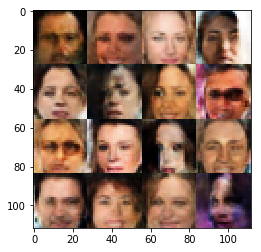

Epoch 1/1... Discriminator Loss: 2.5321... Generator Loss: 0.1393
Epoch 1/1... Discriminator Loss: 2.5424... Generator Loss: 0.1049
Epoch 1/1... Discriminator Loss: 2.5916... Generator Loss: 0.0988
Epoch 1/1... Discriminator Loss: 2.7291... Generator Loss: 0.1307
Epoch 1/1... Discriminator Loss: 2.6890... Generator Loss: 0.1397
Epoch 1/1... Discriminator Loss: 1.9945... Generator Loss: 0.2187
Epoch 1/1... Discriminator Loss: 2.8180... Generator Loss: 0.0745
Epoch 1/1... Discriminator Loss: 2.8000... Generator Loss: 0.0700
Epoch 1/1... Discriminator Loss: 2.1772... Generator Loss: 0.1561
Epoch 1/1... Discriminator Loss: 2.4020... Generator Loss: 0.1842


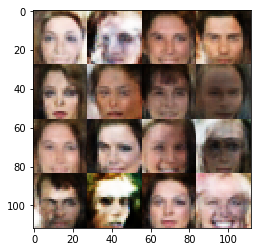

Epoch 1/1... Discriminator Loss: 3.0194... Generator Loss: 0.0856
Epoch 1/1... Discriminator Loss: 2.6506... Generator Loss: 0.1007
Epoch 1/1... Discriminator Loss: 2.3919... Generator Loss: 0.1970
Epoch 1/1... Discriminator Loss: 2.5298... Generator Loss: 0.1132
Epoch 1/1... Discriminator Loss: 2.5562... Generator Loss: 0.1424
Epoch 1/1... Discriminator Loss: 2.4489... Generator Loss: 0.1275
Epoch 1/1... Discriminator Loss: 2.7056... Generator Loss: 0.1214
Epoch 1/1... Discriminator Loss: 2.7156... Generator Loss: 0.0936
Epoch 1/1... Discriminator Loss: 2.9850... Generator Loss: 0.0640
Epoch 1/1... Discriminator Loss: 2.5409... Generator Loss: 0.1383


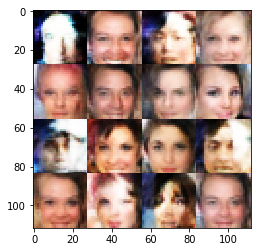

Epoch 1/1... Discriminator Loss: 2.7439... Generator Loss: 0.0909
Epoch 1/1... Discriminator Loss: 2.7686... Generator Loss: 0.0803
Epoch 1/1... Discriminator Loss: 2.7306... Generator Loss: 0.0807
Epoch 1/1... Discriminator Loss: 2.6319... Generator Loss: 0.1054
Epoch 1/1... Discriminator Loss: 2.3674... Generator Loss: 0.1225
Epoch 1/1... Discriminator Loss: 2.4192... Generator Loss: 0.1234
Epoch 1/1... Discriminator Loss: 2.7231... Generator Loss: 0.0838
Epoch 1/1... Discriminator Loss: 3.0846... Generator Loss: 0.0574
Epoch 1/1... Discriminator Loss: 2.8082... Generator Loss: 0.0889
Epoch 1/1... Discriminator Loss: 2.7277... Generator Loss: 0.0994


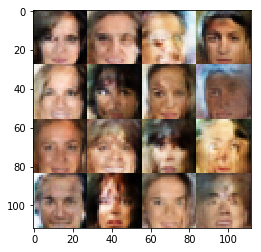

Epoch 1/1... Discriminator Loss: 2.4781... Generator Loss: 0.1511
Epoch 1/1... Discriminator Loss: 2.6986... Generator Loss: 0.0946
Epoch 1/1... Discriminator Loss: 2.5346... Generator Loss: 0.1009
Epoch 1/1... Discriminator Loss: 2.8333... Generator Loss: 0.0708
Epoch 1/1... Discriminator Loss: 2.4189... Generator Loss: 0.1161
Epoch 1/1... Discriminator Loss: 2.6288... Generator Loss: 0.0888
Epoch 1/1... Discriminator Loss: 2.1280... Generator Loss: 0.2725
Epoch 1/1... Discriminator Loss: 2.7310... Generator Loss: 0.1023
Epoch 1/1... Discriminator Loss: 2.6660... Generator Loss: 0.0797
Epoch 1/1... Discriminator Loss: 2.6421... Generator Loss: 0.1064


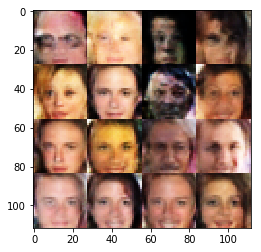

Epoch 1/1... Discriminator Loss: 2.6994... Generator Loss: 0.0997
Epoch 1/1... Discriminator Loss: 2.9604... Generator Loss: 0.1310
Epoch 1/1... Discriminator Loss: 2.8008... Generator Loss: 0.0806
Epoch 1/1... Discriminator Loss: 2.7748... Generator Loss: 0.0773
Epoch 1/1... Discriminator Loss: 2.8249... Generator Loss: 0.1503
Epoch 1/1... Discriminator Loss: 2.8910... Generator Loss: 0.0835
Epoch 1/1... Discriminator Loss: 2.2092... Generator Loss: 0.1741
Epoch 1/1... Discriminator Loss: 2.9475... Generator Loss: 0.0721
Epoch 1/1... Discriminator Loss: 2.7066... Generator Loss: 0.0891
Epoch 1/1... Discriminator Loss: 2.6117... Generator Loss: 0.1010


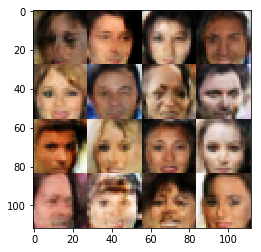

Epoch 1/1... Discriminator Loss: 2.6297... Generator Loss: 0.1219
Epoch 1/1... Discriminator Loss: 2.7896... Generator Loss: 0.0708
Epoch 1/1... Discriminator Loss: 2.5114... Generator Loss: 0.1861
Epoch 1/1... Discriminator Loss: 2.4617... Generator Loss: 0.1271
Epoch 1/1... Discriminator Loss: 2.4805... Generator Loss: 0.1073
Epoch 1/1... Discriminator Loss: 2.3897... Generator Loss: 0.2381
Epoch 1/1... Discriminator Loss: 2.8767... Generator Loss: 0.0783
Epoch 1/1... Discriminator Loss: 2.5071... Generator Loss: 0.1023
Epoch 1/1... Discriminator Loss: 2.3479... Generator Loss: 0.1203
Epoch 1/1... Discriminator Loss: 2.3074... Generator Loss: 0.1557


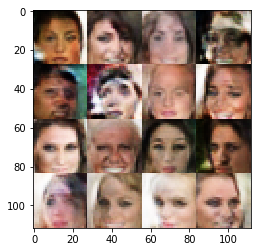

Epoch 1/1... Discriminator Loss: 2.7911... Generator Loss: 0.0762
Epoch 1/1... Discriminator Loss: 2.6788... Generator Loss: 0.1028
Epoch 1/1... Discriminator Loss: 2.6976... Generator Loss: 0.0940
Epoch 1/1... Discriminator Loss: 3.0221... Generator Loss: 0.0914
Epoch 1/1... Discriminator Loss: 2.6292... Generator Loss: 0.0917
Epoch 1/1... Discriminator Loss: 2.7243... Generator Loss: 0.0833
Epoch 1/1... Discriminator Loss: 2.6410... Generator Loss: 0.0870
Epoch 1/1... Discriminator Loss: 2.5164... Generator Loss: 0.1082
Epoch 1/1... Discriminator Loss: 2.4671... Generator Loss: 0.1007
Epoch 1/1... Discriminator Loss: 2.7634... Generator Loss: 0.0757


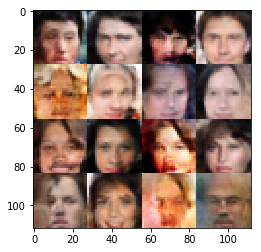

Epoch 1/1... Discriminator Loss: 2.6788... Generator Loss: 0.1138
Epoch 1/1... Discriminator Loss: 2.7240... Generator Loss: 0.0974
Epoch 1/1... Discriminator Loss: 2.3380... Generator Loss: 0.1314
Epoch 1/1... Discriminator Loss: 2.6665... Generator Loss: 0.0917
Epoch 1/1... Discriminator Loss: 2.6010... Generator Loss: 0.0901
Epoch 1/1... Discriminator Loss: 2.5739... Generator Loss: 0.0958
Epoch 1/1... Discriminator Loss: 2.4996... Generator Loss: 0.0989
Epoch 1/1... Discriminator Loss: 2.3599... Generator Loss: 0.2226
Epoch 1/1... Discriminator Loss: 2.6716... Generator Loss: 0.1010
Epoch 1/1... Discriminator Loss: 2.8224... Generator Loss: 0.1628


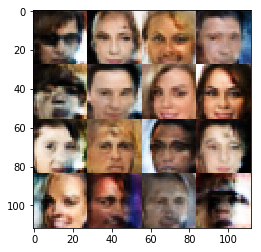

Epoch 1/1... Discriminator Loss: 2.5422... Generator Loss: 0.2048
Epoch 1/1... Discriminator Loss: 2.6894... Generator Loss: 0.0952
Epoch 1/1... Discriminator Loss: 2.5641... Generator Loss: 0.1416
Epoch 1/1... Discriminator Loss: 2.4993... Generator Loss: 0.2029
Epoch 1/1... Discriminator Loss: 2.7788... Generator Loss: 0.0763
Epoch 1/1... Discriminator Loss: 2.6658... Generator Loss: 0.0874
Epoch 1/1... Discriminator Loss: 2.6364... Generator Loss: 0.0924
Epoch 1/1... Discriminator Loss: 2.7168... Generator Loss: 0.0783
Epoch 1/1... Discriminator Loss: 2.3547... Generator Loss: 0.2074
Epoch 1/1... Discriminator Loss: 2.6432... Generator Loss: 0.1047


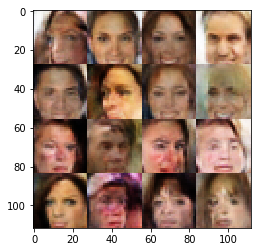

Epoch 1/1... Discriminator Loss: 2.8956... Generator Loss: 0.0661
Epoch 1/1... Discriminator Loss: 2.5108... Generator Loss: 0.1037
Epoch 1/1... Discriminator Loss: 2.7493... Generator Loss: 0.0856
Epoch 1/1... Discriminator Loss: 2.6003... Generator Loss: 0.0911
Epoch 1/1... Discriminator Loss: 2.9593... Generator Loss: 0.0699
Epoch 1/1... Discriminator Loss: 2.3566... Generator Loss: 0.1151
Epoch 1/1... Discriminator Loss: 2.7388... Generator Loss: 0.0840
Epoch 1/1... Discriminator Loss: 2.4795... Generator Loss: 0.1269
Epoch 1/1... Discriminator Loss: 2.4861... Generator Loss: 0.1581
Epoch 1/1... Discriminator Loss: 2.4308... Generator Loss: 0.1242


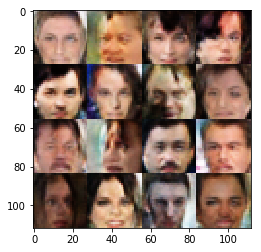

Epoch 1/1... Discriminator Loss: 2.8242... Generator Loss: 0.1234
Epoch 1/1... Discriminator Loss: 2.4131... Generator Loss: 0.2036
Epoch 1/1... Discriminator Loss: 2.5689... Generator Loss: 0.0974
Epoch 1/1... Discriminator Loss: 1.8513... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 2.5931... Generator Loss: 0.1301
Epoch 1/1... Discriminator Loss: 3.0441... Generator Loss: 0.0546
Epoch 1/1... Discriminator Loss: 2.6726... Generator Loss: 0.0985
Epoch 1/1... Discriminator Loss: 2.8943... Generator Loss: 0.0928
Epoch 1/1... Discriminator Loss: 2.3315... Generator Loss: 0.1718
Epoch 1/1... Discriminator Loss: 2.2233... Generator Loss: 0.1670


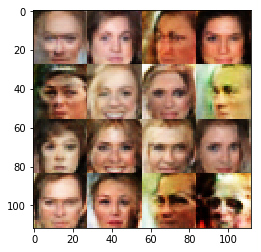

Epoch 1/1... Discriminator Loss: 2.5724... Generator Loss: 0.0881
Epoch 1/1... Discriminator Loss: 3.0714... Generator Loss: 0.0532
Epoch 1/1... Discriminator Loss: 2.7029... Generator Loss: 0.0808
Epoch 1/1... Discriminator Loss: 2.9693... Generator Loss: 0.0893
Epoch 1/1... Discriminator Loss: 2.4942... Generator Loss: 0.0994
Epoch 1/1... Discriminator Loss: 2.4081... Generator Loss: 0.1792
Epoch 1/1... Discriminator Loss: 3.0075... Generator Loss: 0.0653
Epoch 1/1... Discriminator Loss: 2.3325... Generator Loss: 0.1246
Epoch 1/1... Discriminator Loss: 2.6424... Generator Loss: 0.1051
Epoch 1/1... Discriminator Loss: 2.9094... Generator Loss: 0.0864


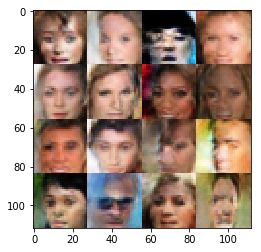

Epoch 1/1... Discriminator Loss: 2.6618... Generator Loss: 0.0872
Epoch 1/1... Discriminator Loss: 2.4899... Generator Loss: 0.1041
Epoch 1/1... Discriminator Loss: 2.8077... Generator Loss: 0.1742
Epoch 1/1... Discriminator Loss: 2.8369... Generator Loss: 0.0759
Epoch 1/1... Discriminator Loss: 2.5806... Generator Loss: 0.1112
Epoch 1/1... Discriminator Loss: 2.5845... Generator Loss: 0.1164
Epoch 1/1... Discriminator Loss: 2.6353... Generator Loss: 0.1704
Epoch 1/1... Discriminator Loss: 2.1157... Generator Loss: 0.1860
Epoch 1/1... Discriminator Loss: 2.3470... Generator Loss: 0.1138
Epoch 1/1... Discriminator Loss: 2.5354... Generator Loss: 0.1008


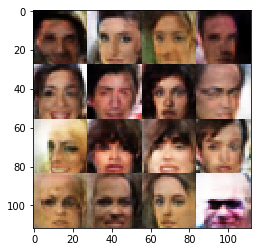

Epoch 1/1... Discriminator Loss: 2.8468... Generator Loss: 0.0806
Epoch 1/1... Discriminator Loss: 3.0412... Generator Loss: 0.0546
Epoch 1/1... Discriminator Loss: 2.4444... Generator Loss: 0.1331
Epoch 1/1... Discriminator Loss: 2.6710... Generator Loss: 0.1272
Epoch 1/1... Discriminator Loss: 2.2158... Generator Loss: 0.2751
Epoch 1/1... Discriminator Loss: 2.7565... Generator Loss: 0.1475
Epoch 1/1... Discriminator Loss: 2.6250... Generator Loss: 0.0918
Epoch 1/1... Discriminator Loss: 2.3734... Generator Loss: 0.1762
Epoch 1/1... Discriminator Loss: 2.5772... Generator Loss: 0.1238
Epoch 1/1... Discriminator Loss: 3.3083... Generator Loss: 0.0451


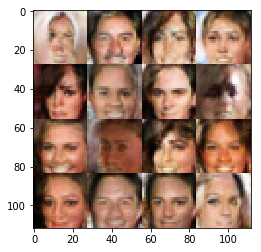

Epoch 1/1... Discriminator Loss: 3.0031... Generator Loss: 0.0576
Epoch 1/1... Discriminator Loss: 2.7194... Generator Loss: 0.0851
Epoch 1/1... Discriminator Loss: 2.7979... Generator Loss: 0.1284
Epoch 1/1... Discriminator Loss: 2.3244... Generator Loss: 0.1786
Epoch 1/1... Discriminator Loss: 2.3014... Generator Loss: 0.1309
Epoch 1/1... Discriminator Loss: 2.5907... Generator Loss: 0.2436
Epoch 1/1... Discriminator Loss: 2.3237... Generator Loss: 0.1572
Epoch 1/1... Discriminator Loss: 2.6309... Generator Loss: 0.1286
Epoch 1/1... Discriminator Loss: 2.7069... Generator Loss: 0.0815
Epoch 1/1... Discriminator Loss: 2.6444... Generator Loss: 0.0996


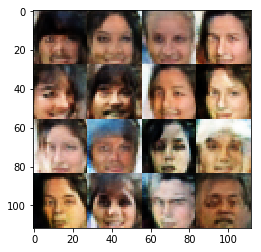

Epoch 1/1... Discriminator Loss: 2.5524... Generator Loss: 0.1266
Epoch 1/1... Discriminator Loss: 2.6958... Generator Loss: 0.0789
Epoch 1/1... Discriminator Loss: 3.1068... Generator Loss: 0.0543
Epoch 1/1... Discriminator Loss: 2.6339... Generator Loss: 0.1571
Epoch 1/1... Discriminator Loss: 2.8191... Generator Loss: 0.0668
Epoch 1/1... Discriminator Loss: 2.4593... Generator Loss: 0.1910
Epoch 1/1... Discriminator Loss: 2.1939... Generator Loss: 0.1675
Epoch 1/1... Discriminator Loss: 2.3528... Generator Loss: 0.2034
Epoch 1/1... Discriminator Loss: 2.2998... Generator Loss: 0.1319
Epoch 1/1... Discriminator Loss: 2.6782... Generator Loss: 0.1375


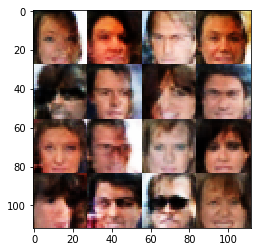

Epoch 1/1... Discriminator Loss: 2.6250... Generator Loss: 0.1117
Epoch 1/1... Discriminator Loss: 2.6750... Generator Loss: 0.0804
Epoch 1/1... Discriminator Loss: 2.9146... Generator Loss: 0.1371
Epoch 1/1... Discriminator Loss: 2.5876... Generator Loss: 0.0861
Epoch 1/1... Discriminator Loss: 2.5449... Generator Loss: 0.1112
Epoch 1/1... Discriminator Loss: 2.4174... Generator Loss: 0.2734
Epoch 1/1... Discriminator Loss: 2.5250... Generator Loss: 0.1149
Epoch 1/1... Discriminator Loss: 2.6728... Generator Loss: 0.0905
Epoch 1/1... Discriminator Loss: 2.6549... Generator Loss: 0.1017
Epoch 1/1... Discriminator Loss: 2.9686... Generator Loss: 0.1087


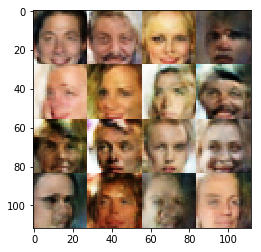

Epoch 1/1... Discriminator Loss: 2.3496... Generator Loss: 0.1845
Epoch 1/1... Discriminator Loss: 2.7921... Generator Loss: 0.0757
Epoch 1/1... Discriminator Loss: 2.8513... Generator Loss: 0.0737
Epoch 1/1... Discriminator Loss: 2.6016... Generator Loss: 0.1021
Epoch 1/1... Discriminator Loss: 2.6822... Generator Loss: 0.0847
Epoch 1/1... Discriminator Loss: 2.4416... Generator Loss: 0.1480
Epoch 1/1... Discriminator Loss: 2.2277... Generator Loss: 0.1318
Epoch 1/1... Discriminator Loss: 3.1565... Generator Loss: 0.0457
Epoch 1/1... Discriminator Loss: 2.7314... Generator Loss: 0.1025
Epoch 1/1... Discriminator Loss: 2.8566... Generator Loss: 0.0684


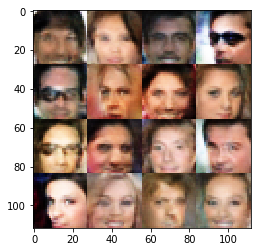

Epoch 1/1... Discriminator Loss: 2.6477... Generator Loss: 0.0902
Epoch 1/1... Discriminator Loss: 2.6895... Generator Loss: 0.0760
Epoch 1/1... Discriminator Loss: 2.4318... Generator Loss: 0.1268
Epoch 1/1... Discriminator Loss: 2.7479... Generator Loss: 0.1071
Epoch 1/1... Discriminator Loss: 2.7726... Generator Loss: 0.0743
Epoch 1/1... Discriminator Loss: 2.6899... Generator Loss: 0.0949
Epoch 1/1... Discriminator Loss: 2.1621... Generator Loss: 0.1308
Epoch 1/1... Discriminator Loss: 2.7146... Generator Loss: 0.1088
Epoch 1/1... Discriminator Loss: 2.2594... Generator Loss: 0.1704
Epoch 1/1... Discriminator Loss: 2.8464... Generator Loss: 0.0669


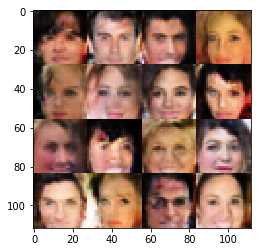

Epoch 1/1... Discriminator Loss: 3.4374... Generator Loss: 0.0711
Epoch 1/1... Discriminator Loss: 2.5949... Generator Loss: 0.1651
Epoch 1/1... Discriminator Loss: 2.5161... Generator Loss: 0.1137
Epoch 1/1... Discriminator Loss: 2.8521... Generator Loss: 0.0663
Epoch 1/1... Discriminator Loss: 2.8485... Generator Loss: 0.1997
Epoch 1/1... Discriminator Loss: 2.6056... Generator Loss: 0.1014
Epoch 1/1... Discriminator Loss: 2.5706... Generator Loss: 0.1161
Epoch 1/1... Discriminator Loss: 3.0359... Generator Loss: 0.2546
Epoch 1/1... Discriminator Loss: 3.1344... Generator Loss: 0.0556
Epoch 1/1... Discriminator Loss: 2.3248... Generator Loss: 0.2183


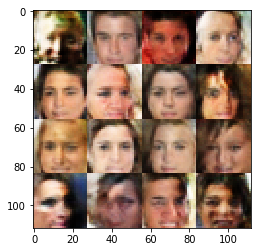

Epoch 1/1... Discriminator Loss: 2.4060... Generator Loss: 0.1371
Epoch 1/1... Discriminator Loss: 2.9279... Generator Loss: 0.0662
Epoch 1/1... Discriminator Loss: 2.8372... Generator Loss: 0.0723
Epoch 1/1... Discriminator Loss: 2.5440... Generator Loss: 0.1741
Epoch 1/1... Discriminator Loss: 2.4631... Generator Loss: 0.1405
Epoch 1/1... Discriminator Loss: 2.4605... Generator Loss: 0.1051
Epoch 1/1... Discriminator Loss: 2.5353... Generator Loss: 0.1079
Epoch 1/1... Discriminator Loss: 2.4420... Generator Loss: 0.1284
Epoch 1/1... Discriminator Loss: 2.4836... Generator Loss: 0.1414
Epoch 1/1... Discriminator Loss: 3.3367... Generator Loss: 0.0409


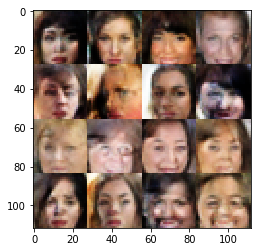

Epoch 1/1... Discriminator Loss: 2.7409... Generator Loss: 0.1481
Epoch 1/1... Discriminator Loss: 2.8698... Generator Loss: 0.0667
Epoch 1/1... Discriminator Loss: 2.7240... Generator Loss: 0.0925
Epoch 1/1... Discriminator Loss: 2.2022... Generator Loss: 0.1364
Epoch 1/1... Discriminator Loss: 2.3010... Generator Loss: 0.1408
Epoch 1/1... Discriminator Loss: 2.7528... Generator Loss: 0.1257
Epoch 1/1... Discriminator Loss: 2.2546... Generator Loss: 0.1217
Epoch 1/1... Discriminator Loss: 2.8835... Generator Loss: 0.0801
Epoch 1/1... Discriminator Loss: 2.9154... Generator Loss: 0.0620
Epoch 1/1... Discriminator Loss: 2.7082... Generator Loss: 0.1020


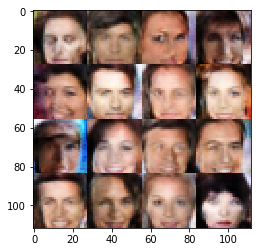

Epoch 1/1... Discriminator Loss: 2.6689... Generator Loss: 0.1025
Epoch 1/1... Discriminator Loss: 2.8231... Generator Loss: 0.0701
Epoch 1/1... Discriminator Loss: 2.5196... Generator Loss: 0.1289
Epoch 1/1... Discriminator Loss: 2.3635... Generator Loss: 0.1784
Epoch 1/1... Discriminator Loss: 3.1551... Generator Loss: 0.0460
Epoch 1/1... Discriminator Loss: 2.6746... Generator Loss: 0.2081
Epoch 1/1... Discriminator Loss: 2.9062... Generator Loss: 0.0792
Epoch 1/1... Discriminator Loss: 2.4722... Generator Loss: 0.1643
Epoch 1/1... Discriminator Loss: 2.3619... Generator Loss: 0.1543
Epoch 1/1... Discriminator Loss: 2.7120... Generator Loss: 0.1054


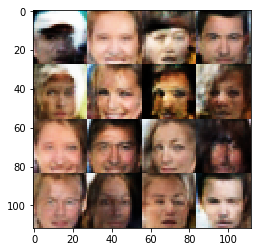

Epoch 1/1... Discriminator Loss: 2.7657... Generator Loss: 0.0930
Epoch 1/1... Discriminator Loss: 2.4591... Generator Loss: 0.1112
Epoch 1/1... Discriminator Loss: 2.3338... Generator Loss: 0.2159
Epoch 1/1... Discriminator Loss: 2.5805... Generator Loss: 0.1508
Epoch 1/1... Discriminator Loss: 2.3209... Generator Loss: 0.1654
Epoch 1/1... Discriminator Loss: 2.5101... Generator Loss: 0.1000
Epoch 1/1... Discriminator Loss: 2.5414... Generator Loss: 0.1245
Epoch 1/1... Discriminator Loss: 2.5054... Generator Loss: 0.1367
Epoch 1/1... Discriminator Loss: 2.9618... Generator Loss: 0.0649
Epoch 1/1... Discriminator Loss: 2.9946... Generator Loss: 0.0640


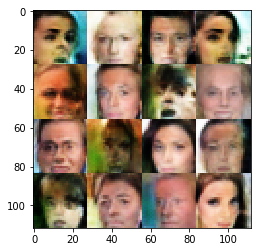

Epoch 1/1... Discriminator Loss: 3.3922... Generator Loss: 0.0637
Epoch 1/1... Discriminator Loss: 2.4512... Generator Loss: 0.1324
Epoch 1/1... Discriminator Loss: 2.3954... Generator Loss: 0.1563
Epoch 1/1... Discriminator Loss: 2.7751... Generator Loss: 0.1189
Epoch 1/1... Discriminator Loss: 2.8626... Generator Loss: 0.0780
Epoch 1/1... Discriminator Loss: 2.5637... Generator Loss: 0.0919
Epoch 1/1... Discriminator Loss: 1.9851... Generator Loss: 0.2313
Epoch 1/1... Discriminator Loss: 2.2640... Generator Loss: 0.1876
Epoch 1/1... Discriminator Loss: 2.4453... Generator Loss: 0.1058
Epoch 1/1... Discriminator Loss: 2.4219... Generator Loss: 0.1100


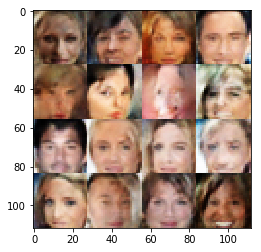

Epoch 1/1... Discriminator Loss: 2.7416... Generator Loss: 0.1138
Epoch 1/1... Discriminator Loss: 2.6346... Generator Loss: 0.0898
Epoch 1/1... Discriminator Loss: 2.7385... Generator Loss: 0.0945
Epoch 1/1... Discriminator Loss: 2.1151... Generator Loss: 0.2515
Epoch 1/1... Discriminator Loss: 2.7301... Generator Loss: 0.0798
Epoch 1/1... Discriminator Loss: 2.3811... Generator Loss: 0.1599
Epoch 1/1... Discriminator Loss: 2.7962... Generator Loss: 0.0831
Epoch 1/1... Discriminator Loss: 3.2198... Generator Loss: 0.0498
Epoch 1/1... Discriminator Loss: 2.8498... Generator Loss: 0.0630
Epoch 1/1... Discriminator Loss: 3.0043... Generator Loss: 0.0590


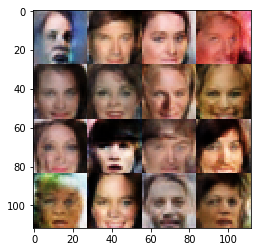

Epoch 1/1... Discriminator Loss: 2.8627... Generator Loss: 0.0847
Epoch 1/1... Discriminator Loss: 2.4961... Generator Loss: 0.0903
Epoch 1/1... Discriminator Loss: 2.8542... Generator Loss: 0.1180
Epoch 1/1... Discriminator Loss: 3.0718... Generator Loss: 0.0554
Epoch 1/1... Discriminator Loss: 2.4678... Generator Loss: 0.1102
Epoch 1/1... Discriminator Loss: 2.5080... Generator Loss: 0.1264
Epoch 1/1... Discriminator Loss: 2.6808... Generator Loss: 0.2071
Epoch 1/1... Discriminator Loss: 2.0341... Generator Loss: 0.2646
Epoch 1/1... Discriminator Loss: 2.4755... Generator Loss: 0.1105
Epoch 1/1... Discriminator Loss: 3.0966... Generator Loss: 0.0548


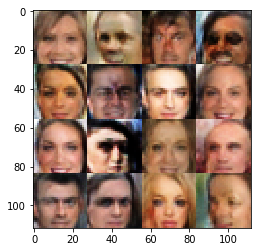

Epoch 1/1... Discriminator Loss: 2.5299... Generator Loss: 0.1093
Epoch 1/1... Discriminator Loss: 2.9257... Generator Loss: 0.0727
Epoch 1/1... Discriminator Loss: 2.4550... Generator Loss: 0.1163
Epoch 1/1... Discriminator Loss: 3.2689... Generator Loss: 0.0457
Epoch 1/1... Discriminator Loss: 2.8565... Generator Loss: 0.1086
Epoch 1/1... Discriminator Loss: 2.9734... Generator Loss: 0.1526
Epoch 1/1... Discriminator Loss: 2.6317... Generator Loss: 0.1092
Epoch 1/1... Discriminator Loss: 2.6278... Generator Loss: 0.0895
Epoch 1/1... Discriminator Loss: 3.2215... Generator Loss: 0.0470
Epoch 1/1... Discriminator Loss: 2.7515... Generator Loss: 0.0754


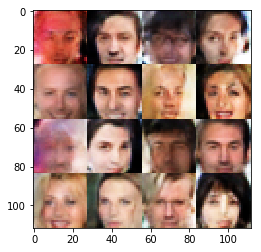

Epoch 1/1... Discriminator Loss: 2.4874... Generator Loss: 0.1202
Epoch 1/1... Discriminator Loss: 2.9703... Generator Loss: 0.0605
Epoch 1/1... Discriminator Loss: 2.9928... Generator Loss: 0.0585
Epoch 1/1... Discriminator Loss: 2.9627... Generator Loss: 0.0619
Epoch 1/1... Discriminator Loss: 2.4911... Generator Loss: 0.1181
Epoch 1/1... Discriminator Loss: 2.7531... Generator Loss: 0.0981
Epoch 1/1... Discriminator Loss: 3.0494... Generator Loss: 0.0551
Epoch 1/1... Discriminator Loss: 2.6629... Generator Loss: 0.1476
Epoch 1/1... Discriminator Loss: 2.7381... Generator Loss: 0.0767
Epoch 1/1... Discriminator Loss: 2.5702... Generator Loss: 0.1346


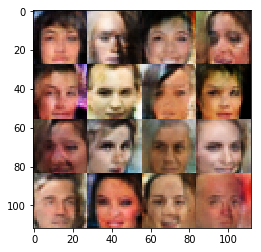

Epoch 1/1... Discriminator Loss: 2.4101... Generator Loss: 0.4543
Epoch 1/1... Discriminator Loss: 2.8716... Generator Loss: 0.0888
Epoch 1/1... Discriminator Loss: 2.7737... Generator Loss: 0.1122
Epoch 1/1... Discriminator Loss: 2.3540... Generator Loss: 0.1219
Epoch 1/1... Discriminator Loss: 2.5236... Generator Loss: 0.0925
Epoch 1/1... Discriminator Loss: 3.2136... Generator Loss: 0.0489
Epoch 1/1... Discriminator Loss: 2.7070... Generator Loss: 0.0865
Epoch 1/1... Discriminator Loss: 2.8943... Generator Loss: 0.0930
Epoch 1/1... Discriminator Loss: 2.8357... Generator Loss: 0.0637
Epoch 1/1... Discriminator Loss: 2.5482... Generator Loss: 0.1150


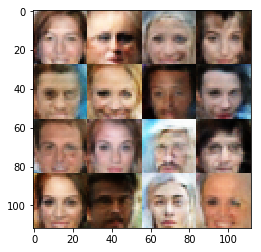

Epoch 1/1... Discriminator Loss: 2.4077... Generator Loss: 0.1312
Epoch 1/1... Discriminator Loss: 2.5089... Generator Loss: 0.1298
Epoch 1/1... Discriminator Loss: 2.4879... Generator Loss: 0.1068
Epoch 1/1... Discriminator Loss: 4.0516... Generator Loss: 0.0713
Epoch 1/1... Discriminator Loss: 2.9585... Generator Loss: 0.1318
Epoch 1/1... Discriminator Loss: 2.8532... Generator Loss: 0.0621
Epoch 1/1... Discriminator Loss: 2.1471... Generator Loss: 0.1984
Epoch 1/1... Discriminator Loss: 2.9875... Generator Loss: 0.0648
Epoch 1/1... Discriminator Loss: 2.7871... Generator Loss: 0.0710
Epoch 1/1... Discriminator Loss: 2.9074... Generator Loss: 0.0631


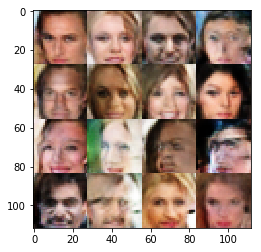

Epoch 1/1... Discriminator Loss: 2.6036... Generator Loss: 0.0879
Epoch 1/1... Discriminator Loss: 2.5625... Generator Loss: 0.1388
Epoch 1/1... Discriminator Loss: 3.0721... Generator Loss: 0.0718
Epoch 1/1... Discriminator Loss: 2.4429... Generator Loss: 0.1027
Epoch 1/1... Discriminator Loss: 2.6527... Generator Loss: 0.0866
Epoch 1/1... Discriminator Loss: 2.5003... Generator Loss: 0.1327
Epoch 1/1... Discriminator Loss: 2.9258... Generator Loss: 0.0698
Epoch 1/1... Discriminator Loss: 2.7885... Generator Loss: 0.0778
Epoch 1/1... Discriminator Loss: 1.9521... Generator Loss: 0.2215
Epoch 1/1... Discriminator Loss: 2.6028... Generator Loss: 0.0862


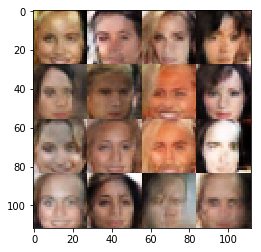

Epoch 1/1... Discriminator Loss: 2.3666... Generator Loss: 0.1345
Epoch 1/1... Discriminator Loss: 2.7481... Generator Loss: 0.0903
Epoch 1/1... Discriminator Loss: 2.8100... Generator Loss: 0.0731
Epoch 1/1... Discriminator Loss: 2.9336... Generator Loss: 0.0594
Epoch 1/1... Discriminator Loss: 2.6641... Generator Loss: 0.0830
Epoch 1/1... Discriminator Loss: 2.4744... Generator Loss: 0.1511
Epoch 1/1... Discriminator Loss: 2.5709... Generator Loss: 0.1069
Epoch 1/1... Discriminator Loss: 2.7199... Generator Loss: 0.0902
Epoch 1/1... Discriminator Loss: 2.9328... Generator Loss: 0.0620
Epoch 1/1... Discriminator Loss: 3.1513... Generator Loss: 0.0664


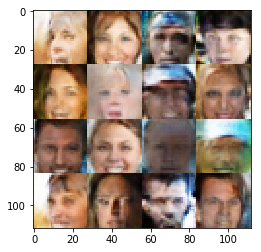

Epoch 1/1... Discriminator Loss: 2.3654... Generator Loss: 0.1263
Epoch 1/1... Discriminator Loss: 2.9227... Generator Loss: 0.0663
Epoch 1/1... Discriminator Loss: 2.5065... Generator Loss: 0.0920
Epoch 1/1... Discriminator Loss: 2.6352... Generator Loss: 0.1526
Epoch 1/1... Discriminator Loss: 2.5455... Generator Loss: 0.1135
Epoch 1/1... Discriminator Loss: 2.4540... Generator Loss: 0.1254
Epoch 1/1... Discriminator Loss: 2.3346... Generator Loss: 0.1291
Epoch 1/1... Discriminator Loss: 2.9114... Generator Loss: 0.0638
Epoch 1/1... Discriminator Loss: 3.2289... Generator Loss: 0.0628
Epoch 1/1... Discriminator Loss: 3.1444... Generator Loss: 0.0611


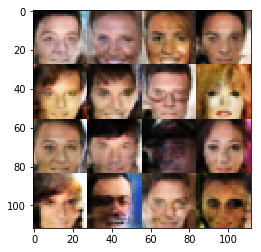

Epoch 1/1... Discriminator Loss: 3.0092... Generator Loss: 0.1115
Epoch 1/1... Discriminator Loss: 2.5567... Generator Loss: 0.0915
Epoch 1/1... Discriminator Loss: 2.7776... Generator Loss: 0.1274
Epoch 1/1... Discriminator Loss: 3.1842... Generator Loss: 0.0486
Epoch 1/1... Discriminator Loss: 2.9312... Generator Loss: 0.0621
Epoch 1/1... Discriminator Loss: 2.6739... Generator Loss: 0.1141
Epoch 1/1... Discriminator Loss: 2.6055... Generator Loss: 0.1130
Epoch 1/1... Discriminator Loss: 2.8189... Generator Loss: 0.0707
Epoch 1/1... Discriminator Loss: 2.9799... Generator Loss: 0.0616
Epoch 1/1... Discriminator Loss: 2.9573... Generator Loss: 0.0774


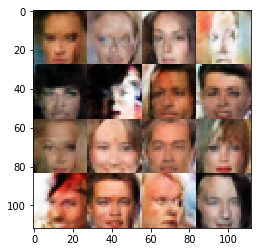

Epoch 1/1... Discriminator Loss: 2.6438... Generator Loss: 0.0826
Epoch 1/1... Discriminator Loss: 2.3963... Generator Loss: 0.1461
Epoch 1/1... Discriminator Loss: 2.9318... Generator Loss: 0.0642
Epoch 1/1... Discriminator Loss: 2.2990... Generator Loss: 0.1800
Epoch 1/1... Discriminator Loss: 2.5748... Generator Loss: 0.1093
Epoch 1/1... Discriminator Loss: 3.7510... Generator Loss: 0.2417
Epoch 1/1... Discriminator Loss: 2.1552... Generator Loss: 0.1736
Epoch 1/1... Discriminator Loss: 2.7657... Generator Loss: 0.1236
Epoch 1/1... Discriminator Loss: 3.0260... Generator Loss: 0.1097
Epoch 1/1... Discriminator Loss: 2.6423... Generator Loss: 0.0831


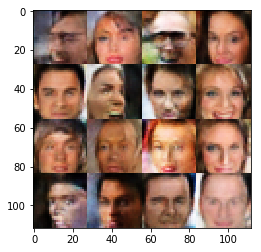

Epoch 1/1... Discriminator Loss: 2.6245... Generator Loss: 0.1038
Epoch 1/1... Discriminator Loss: 2.6182... Generator Loss: 0.1232
Epoch 1/1... Discriminator Loss: 3.0826... Generator Loss: 0.0678
Epoch 1/1... Discriminator Loss: 2.7238... Generator Loss: 0.0957
Epoch 1/1... Discriminator Loss: 2.9624... Generator Loss: 0.0592
Epoch 1/1... Discriminator Loss: 3.1132... Generator Loss: 0.0564


In [100]:
batch_size = 16
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.